<a href="https://colab.research.google.com/github/paolaCaushi/anomalyDetectionWithTransferLearning/blob/autoencoderVAE_Update/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***VAE FOR ANOMALY DETECTION***

Number of rows (including header): 2670
Number of columns: 9

Sample of the data (first 5 rows):
   idAnomalia idConcentratore        dataAnomalia latitudine longitudine  \
0    18526375        SR013287 2023-05-26 12:16:28    39,2512      9,1338   
1    18699686        SR013287 2023-01-11 13:46:47    39,2585      9,0723   
2    19367851        SR013279 2022-10-10 08:42:46     40,124     18,3356   
3    21068660        SR013279 2022-03-26 07:52:15    41,2507     16,2203   
4    21076623        SR010385 2022-03-28 06:58:52    44,2287     12,0657   

       dataCoordinate        dataSegnalazione note  idPunto  Target  
0 2023-05-26 12:16:28 2015-04-22 14:24:01.353  NaN      NaN       0  
1 2023-01-11 13:46:47 2015-06-27 09:05:07.203  NaN  45267.0       0  
2 2022-10-10 08:42:46 2015-10-12 09:07:23.653  NaN  42607.0       0  
3 2022-03-26 07:52:15 2016-04-16 09:01:19.923  NaN  40981.0       0  
4 2022-03-28 06:58:52 2016-04-18 07:13:12.357  NaN      NaN       0  

Distribution of target va

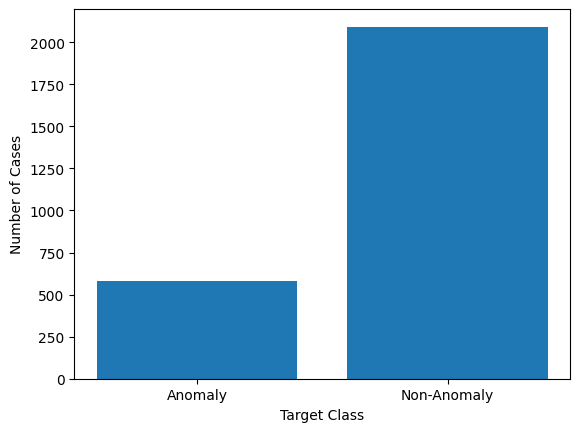

Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.6227 - val_loss: 0.2175
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1337 - val_loss: 0.0246
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0193 - val_loss: 0.0114
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0104 - val_loss: 0.0093
Epoch 5/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0080 - val_loss: 0.0079
Epoch 6/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0074 - val_loss: 0.0074
Epoch 7/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0069 - val_loss: 0.0075
Epoch 8/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0072 - val_loss: 0.0076
Epoch 9/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0069 - val_loss: 0.0073
Epoch 10/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0070 - val_loss: 0.0071
Epoch 11/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0063 - val_loss: 0.0072
Epoch 12/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

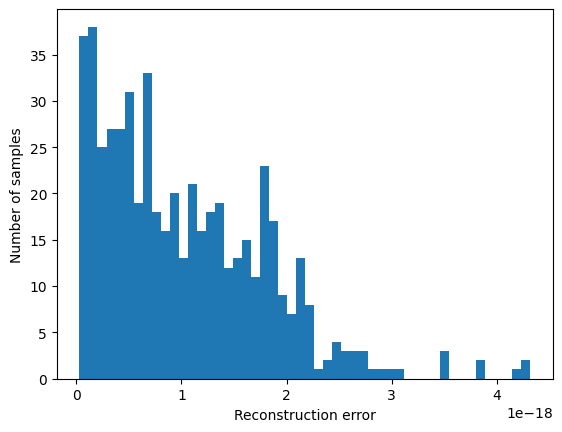

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import layers, models, losses

# Specify the path to the Excel file
data_file = "Anomalies_2021_2024.xlsx"

# Read data from Excel into a DataFrame
df = pd.read_excel(data_file, sheet_name="Sheet1", header=0)

# Print basic information about the data
print(f"Number of rows (including header): {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

# Create target variable based on 'idPunto' being null and 'note' being 12 or 6
df['Target'] = df.apply(lambda row: 1 if pd.isnull(row['idPunto']) and row['note'] in [12, 6] else 0, axis=1)

# Print a sample of the data (first 5 rows)
print("\nSample of the data (first 5 rows):")
print(df.head())

# Print the distribution of the target variable
anomaly_count = df['Target'].sum()
non_anomaly_count = df.shape[0] - anomaly_count
print(f"\nDistribution of target variable:")
print(f"--- Anomaly cases (idPunto NULL and note 12 or 6): {anomaly_count}")
print(f"--- Non-Anomaly cases: {non_anomaly_count}")

# Visualize the distribution with a bar chart
plt.bar(["Anomaly", "Non-Anomaly"], [anomaly_count, non_anomaly_count])
plt.xlabel("Target Class")
plt.ylabel("Number of Cases")
plt.show()

# Drop the 'idPunto' and 'note' columns and convert datetime columns
df = df.drop(columns=['idPunto', 'note'])

# Convert datetime columns to numeric
datetime_columns = ['dataAnomalia', 'dataCoordinate', 'dataSegnalazione']
for col in datetime_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce').astype('int64') // 10**9

# Fill NaN values in datetime columns with median
for col in datetime_columns:
    df[col].fillna(df[col].median(), inplace=True)

# Convert categorical columns to string type
categorical_features = df.select_dtypes(include=['object']).columns
df[categorical_features] = df[categorical_features].astype(str)

# Separate features and target variable
X = df.drop(columns=['Target'])
y = df['Target']

# Identify numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Define preprocessing pipelines for numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing pipelines into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Apply preprocessing to the features
X_preprocessed = preprocessor.fit_transform(X)

# Convert the sparse matrix to a dense array
X_preprocessed = X_preprocessed.toarray()

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Define the VAE model
def build_vae(input_shape, latent_dim):
    inputs = layers.Input(shape=(input_shape,))

    # Encoder
    x = layers.Dense(64, activation='relu')(inputs)
    x = layers.Dense(32, activation='relu')(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)

    def sampling(args):
        z_mean, z_log_var = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = layers.Lambda(sampling)([z_mean, z_log_var])

    # Decoder
    decoder_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(32, activation='relu')(decoder_inputs)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(input_shape, activation='sigmoid')(x)

    encoder = models.Model(inputs, [z_mean, z_log_var, z])
    decoder = models.Model(decoder_inputs, outputs)

    vae_outputs = decoder(encoder(inputs)[2])
    vae = models.Model(inputs, vae_outputs)

    # Custom loss layer for reconstruction loss
    class CustomVariationalLayer(layers.Layer):
        def vae_loss(self, x, z_mean, z_log_var, x_decoded_mean):
            xent_loss = tf.keras.losses.binary_crossentropy(x, x_decoded_mean)
            kl_loss = - 0.5 * tf.reduce_sum(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1, axis=-1)
            return tf.reduce_mean(xent_loss + kl_loss)

        def call(self, inputs):
            x = inputs[0]
            z_mean = inputs[1]
            z_log_var = inputs[2]
            x_decoded_mean = inputs[3]
            loss = self.vae_loss(x, z_mean, z_log_var, x_decoded_mean)
            self.add_loss(loss)
            return x

    custom_layer = CustomVariationalLayer()([inputs, z_mean, z_log_var, vae_outputs])

    vae = models.Model(inputs, custom_layer)
    vae.compile(optimizer='adam')

    return vae, encoder, decoder

# Build the VAE model
input_shape = X_train.shape[1]
latent_dim = 2  # Example latent dimension
vae, encoder, decoder = build_vae(input_shape, latent_dim)

# Train the VAE
history = vae.fit(X_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Predict on the test set
X_test_pred = vae.predict(X_test)

# Calculate reconstruction error
reconstruction_loss = np.mean(np.square(X_test - X_test_pred), axis=1)

# Define a threshold for anomaly detection
threshold = np.percentile(reconstruction_loss, 90)  # 90th percentile can be considered as the threshold

# Identify anomalies
y_pred = (reconstruction_loss > threshold).astype(int)

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Visualize the reconstruction error
plt.hist(reconstruction_loss, bins=50)
plt.xlabel("Reconstruction error")
plt.ylabel("Number of samples")
plt.show()


# **Me SMOTE**

Number of rows (including header): 2670
Number of columns: 9

Sample of the data (first 5 rows):
   idAnomalia idConcentratore        dataAnomalia latitudine longitudine  \
0    18526375        SR013287 2023-05-26 12:16:28    39,2512      9,1338   
1    18699686        SR013287 2023-01-11 13:46:47    39,2585      9,0723   
2    19367851        SR013279 2022-10-10 08:42:46     40,124     18,3356   
3    21068660        SR013279 2022-03-26 07:52:15    41,2507     16,2203   
4    21076623        SR010385 2022-03-28 06:58:52    44,2287     12,0657   

       dataCoordinate        dataSegnalazione note  idPunto  Target  
0 2023-05-26 12:16:28 2015-04-22 14:24:01.353  NaN      NaN       0  
1 2023-01-11 13:46:47 2015-06-27 09:05:07.203  NaN  45267.0       0  
2 2022-10-10 08:42:46 2015-10-12 09:07:23.653  NaN  42607.0       0  
3 2022-03-26 07:52:15 2016-04-16 09:01:19.923  NaN  40981.0       0  
4 2022-03-28 06:58:52 2016-04-18 07:13:12.357  NaN      NaN       0  

Distribution of target va

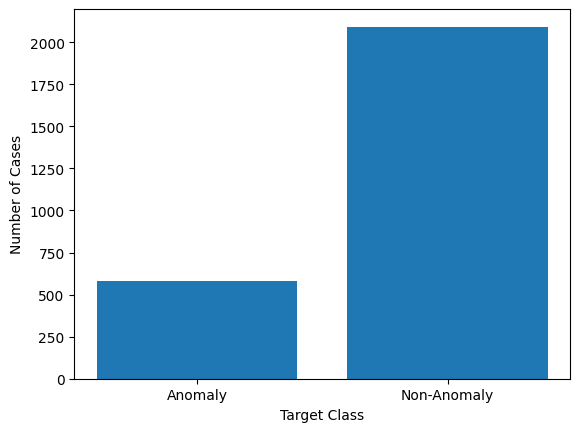

Epoch 1/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.6262 - val_loss: 0.2300
Epoch 2/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1302 - val_loss: 0.0224
Epoch 3/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0185 - val_loss: 0.0110
Epoch 4/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0095 - val_loss: 0.0086
Epoch 5/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0077 - val_loss: 0.0079
Epoch 6/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0069 - val_loss: 0.0075
Epoch 7/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0068 - val_loss: 0.0075
Epoch 8/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0064 - val_loss: 0.0072
Epoch 9/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0073 - val_loss: 0.0072
Epoch 10/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0064 - val_loss: 0.0072
Epoch 11/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0059 - val_loss: 0.0074
Epoch 12/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

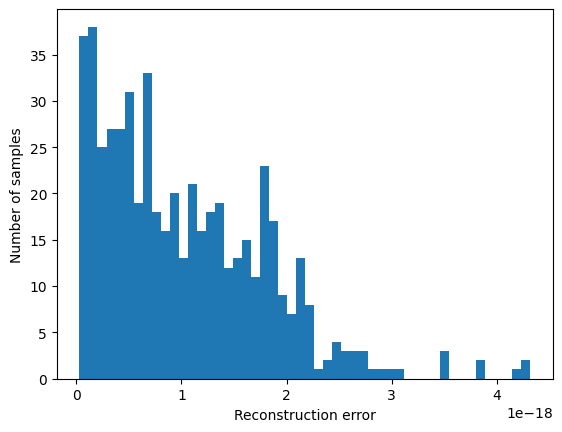

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import layers, models, losses

# Specify the path to the Excel file
data_file = "Anomalies_2021_2024.xlsx"

# Read data from Excel into a DataFrame
df = pd.read_excel(data_file, sheet_name="Sheet1", header=0)

# Print basic information about the data
print(f"Number of rows (including header): {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

# Create target variable based on 'idPunto' being null and 'note' being 12 or 6
df['Target'] = df.apply(lambda row: 1 if pd.isnull(row['idPunto']) and row['note'] in [12, 6] else 0, axis=1)

# Print a sample of the data (first 5 rows)
print("\nSample of the data (first 5 rows):")
print(df.head())

# Print the distribution of the target variable
anomaly_count = df['Target'].sum()
non_anomaly_count = df.shape[0] - anomaly_count
print(f"\nDistribution of target variable:")
print(f"--- Anomaly cases (idPunto NULL and note 12 or 6): {anomaly_count}")
print(f"--- Non-Anomaly cases: {non_anomaly_count}")

# Visualize the distribution with a bar chart
plt.bar(["Anomaly", "Non-Anomaly"], [anomaly_count, non_anomaly_count])
plt.xlabel("Target Class")
plt.ylabel("Number of Cases")
plt.show()

# Drop the 'idPunto' and 'note' columns and convert datetime columns
df = df.drop(columns=['idPunto', 'note'])

# Convert datetime columns to numeric
datetime_columns = ['dataAnomalia', 'dataCoordinate', 'dataSegnalazione']
for col in datetime_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce').astype('int64') // 10**9

# Fill NaN values in datetime columns with median
for col in datetime_columns:
    df[col].fillna(df[col].median(), inplace=True)

# Convert categorical columns to string type
categorical_features = df.select_dtypes(include=['object']).columns
df[categorical_features] = df[categorical_features].astype(str)

# Separate features and target variable
X = df.drop(columns=['Target'])
y = df['Target']

# Identify numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Define preprocessing pipelines for numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing pipelines into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Apply preprocessing to the features
X_preprocessed = preprocessor.fit_transform(X)

# Convert the sparse matrix to a dense array
X_preprocessed = X_preprocessed.toarray()

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Define the VAE model with simplified architecture
def build_vae(input_shape, latent_dim):
    inputs = layers.Input(shape=(input_shape,))

    # Encoder
    x = layers.Dense(128, activation='relu')(inputs)
    x = layers.Dense(64, activation='relu')(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)

    def sampling(args):
        z_mean, z_log_var = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = layers.Lambda(sampling)([z_mean, z_log_var])

    # Decoder
    decoder_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(32, activation='relu')(decoder_inputs)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(input_shape, activation='sigmoid')(x)

    encoder = models.Model(inputs, [z_mean, z_log_var, z])
    decoder = models.Model(decoder_inputs, outputs)

    vae_outputs = decoder(encoder(inputs)[2])
    vae = models.Model(inputs, vae_outputs)

    # Custom loss layer for reconstruction loss
    class CustomVariationalLayer(layers.Layer):
        def vae_loss(self, x, z_mean, z_log_var, x_decoded_mean):
            xent_loss = tf.keras.losses.binary_crossentropy(x, x_decoded_mean)
            kl_loss = - 0.5 * tf.reduce_sum(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1, axis=-1)
            return tf.reduce_mean(xent_loss + kl_loss)

        def call(self, inputs):
            x = inputs[0]
            z_mean = inputs[1]
            z_log_var = inputs[2]
            x_decoded_mean = inputs[3]
            loss = self.vae_loss(x, z_mean, z_log_var, x_decoded_mean)
            self.add_loss(loss)
            return x

    custom_layer = CustomVariationalLayer()([inputs, z_mean, z_log_var, vae_outputs])

    vae = models.Model(inputs, custom_layer)
    vae.compile(optimizer='adam')

    return vae, encoder, decoder


# Build the VAE model with simplified architecture
input_shape = X_train.shape[1]
latent_dim = 2  # Using a smaller latent dimension
vae, encoder, decoder = build_vae(input_shape, latent_dim)

# Train the VAE
history = vae.fit(X_train, epochs=200, batch_size=32, validation_split=0.2, verbose=1)

# Predict on the test set
X_test_pred = vae.predict(X_test)

# Calculate reconstruction error
reconstruction_loss = np.mean(np.square(X_test - X_test_pred), axis=1)

# Define a threshold for anomaly detection
threshold = np.percentile(reconstruction_loss, 85)  # Adjusting the threshold
y_pred = (reconstruction_loss > threshold).astype(int)

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Visualize the reconstruction error
plt.hist(reconstruction_loss, bins=50)
plt.xlabel("Reconstruction error")
plt.ylabel("Number of samples")
plt.show()


TRYING TO FIX METRIS MEASURMENTS

Epoch 1/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: -846779.8125 - val_loss: -833161.1875 - learning_rate: 0.0010
Epoch 2/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: -959471.7500 - val_loss: -882761.2500 - learning_rate: 0.0010
Epoch 3/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -966946.7500 - val_loss: -933106.6875 - learning_rate: 0.0010
Epoch 4/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -1016430.4375 - val_loss: -987602.0000 - learning_rate: 0.0010
Epoch 5/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: -1086175.8750 - val_loss: -1043422.5625 - learning_rate: 0.0010
Epoch 6/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: -1175637.2500 - val_loss: -1101661.1250 - learning_rate: 0.0010
Epoch 7/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: -1189283.3750 - val_loss: -1161826.3750 - learning_rate: 0.0010
Epoch 8/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: -1279302.3750 - val_loss: -1224647.8750 - learning_rate: 0.0010
Epoch 9/200
54/

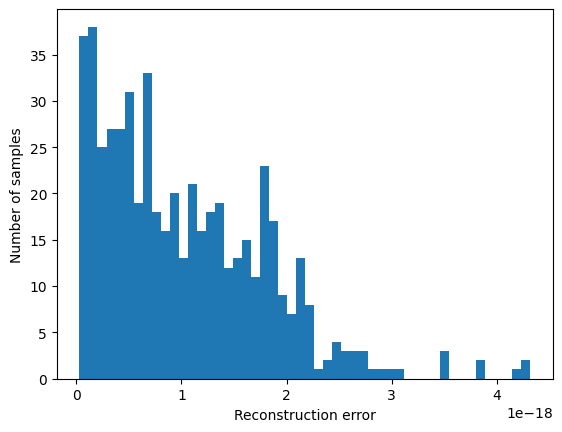

In [12]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# Train the VAE
history = vae.fit(X_train, X_train, epochs=200, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping, reduce_lr])

# Predict on the test set
X_test_pred = vae.predict(X_test)

# Calculate reconstruction error
reconstruction_loss = np.mean(np.square(X_test - X_test_pred), axis=1)

# Define a threshold for anomaly detection
threshold = np.percentile(reconstruction_loss, 95)
y_pred = (reconstruction_loss > threshold).astype(int)

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Visualize the reconstruction error
plt.hist(reconstruction_loss, bins=50)
plt.xlabel("Reconstruction error")
plt.ylabel("Number of samples")
plt.show()


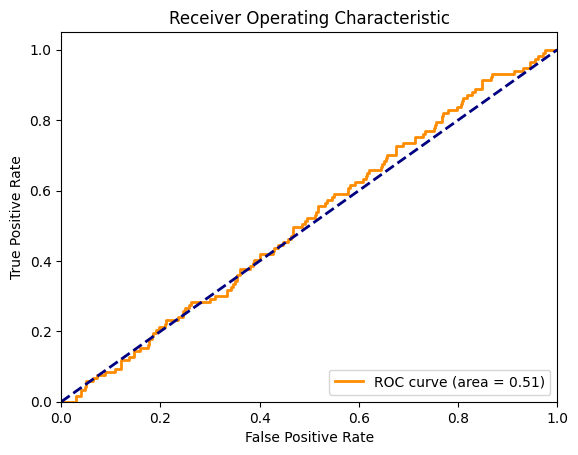


Classification Report with Optimal Threshold:
              precision    recall  f1-score   support

           0       0.85      0.15      0.26       417
           1       0.23      0.91      0.37       117

    accuracy                           0.32       534
   macro avg       0.54      0.53      0.31       534
weighted avg       0.72      0.32      0.28       534



In [13]:
from sklearn.metrics import roc_curve, auc

# Calculate reconstruction error
reconstruction_loss = np.mean(np.square(X_test - X_test_pred), axis=1)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, reconstruction_loss)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Find optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Use the optimal threshold for anomaly detection
y_pred_optimal = (reconstruction_loss > optimal_threshold).astype(int)

# Print the classification report
print("\nClassification Report with Optimal Threshold:")
print(classification_report(y_test, y_pred_optimal))



TRYING TO IMPROVE

Epoch 1/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 3332.6548 - val_loss: 3062.1428 - learning_rate: 0.0010
Epoch 2/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 2798.6914 - val_loss: 2775.3540 - learning_rate: 0.0010
Epoch 3/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 2765.8523 - val_loss: 2718.8330 - learning_rate: 0.0010
Epoch 4/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 2792.6907 - val_loss: 2703.4275 - learning_rate: 0.0010
Epoch 5/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 2836.5161 - val_loss: 2696.7126 - learning_rate: 0.0010
Epoch 6/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 2754.4167 - val_loss: 2694.1145 - learning_rate: 0.0010
Epoch 7/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 2787.8362 - val_loss: 2692.1975 - learning_rate: 0.0010
Epoch 8/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 2680.4841 - val_loss: 2691.0312 - learning_rate: 0.0010
Epoch 9/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 2816.5549 - 

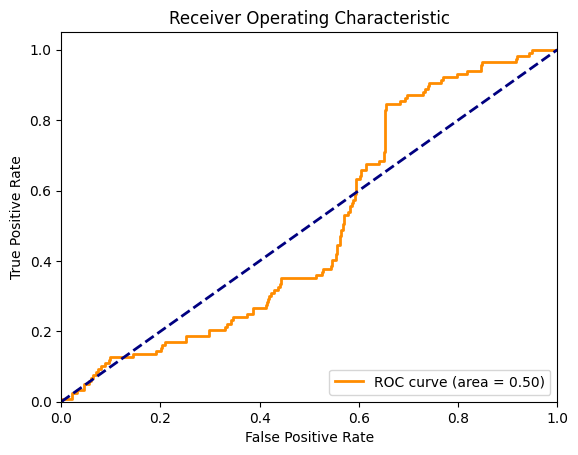

Optimal threshold: 0.011482259398855235

Classification Report with Optimal Threshold:
              precision    recall  f1-score   support

           0       0.88      0.35      0.50       417
           1       0.26      0.84      0.40       117

    accuracy                           0.45       534
   macro avg       0.57      0.59      0.45       534
weighted avg       0.75      0.45      0.48       534



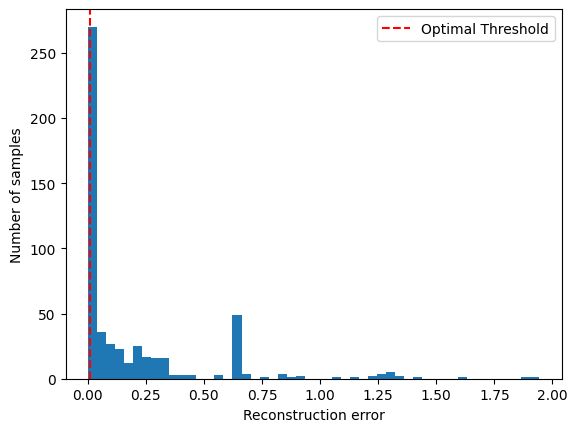

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, BatchNormalization, Activation, Dropout, Layer
from tensorflow.keras import backend as K
#from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, auc
import tensorflow as tf

mse = tf.keras.losses.MeanSquaredError()

class Sampling(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class VAE_LossLayer(Layer):
    def __init__(self, input_dim, **kwargs):
        self.input_dim = input_dim
        super(VAE_LossLayer, self).__init__(**kwargs)


    def vae_loss(self, inputs, outputs, z_mean, z_log_var):
        reconstruction_loss = mse(inputs, outputs)
        reconstruction_loss *= self.input_dim
        kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5
        return K.mean(reconstruction_loss + kl_loss)

    def call(self, inputs):
        inputs, outputs, z_mean, z_log_var = inputs
        loss = self.vae_loss(inputs, outputs, z_mean, z_log_var)
        self.add_loss(loss)
        return outputs

def build_vae(input_dim, latent_dim=10):
    inputs = Input(shape=(input_dim,))
    h = Dense(256)(inputs)
    h = BatchNormalization()(h)
    h = Activation('elu')(h)
    h = Dropout(0.3)(h)
    h = Dense(128)(h)
    h = BatchNormalization()(h)
    h = Activation('elu')(h)
    h = Dropout(0.3)(h)

    z_mean = Dense(latent_dim)(h)
    z_log_var = Dense(latent_dim)(h)

    z = Sampling()([z_mean, z_log_var])

    decoder_h1 = Dense(128)
    decoder_h2 = Dense(256)
    decoder_mean = Dense(input_dim, activation='sigmoid')

    h_decoded1 = decoder_h1(z)
    h_decoded1 = BatchNormalization()(h_decoded1)
    h_decoded1 = Activation('elu')(h_decoded1)
    h_decoded1 = Dropout(0.3)(h_decoded1)
    h_decoded2 = decoder_h2(h_decoded1)
    h_decoded2 = BatchNormalization()(h_decoded2)
    h_decoded2 = Activation('elu')(h_decoded2)
    h_decoded2 = Dropout(0.3)(h_decoded2)
    outputs = decoder_mean(h_decoded2)

    vae_loss_layer = VAE_LossLayer(input_dim)([inputs, outputs, z_mean, z_log_var])

    vae = Model(inputs, vae_loss_layer)
    vae.compile(optimizer='adam')
    return vae

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

input_dim = X_train_scaled.shape[1]
vae = build_vae(input_dim)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

history = vae.fit(X_train_scaled, X_train_scaled, epochs=200, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping, reduce_lr])

X_test_pred = vae.predict(X_test_scaled)

reconstruction_loss = np.mean(np.square(X_test_scaled - X_test_pred), axis=1)

fpr, tpr, thresholds = roc_curve(y_test, reconstruction_loss)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold: {optimal_threshold}")

y_pred_optimal = (reconstruction_loss > optimal_threshold).astype(int)

print("\nClassification Report with Optimal Threshold:")
print(classification_report(y_test, y_pred_optimal))

plt.hist(reconstruction_loss, bins=50)
plt.axvline(x=optimal_threshold, color='red', linestyle='--', label='Optimal Threshold')
plt.xlabel("Reconstruction error")
plt.ylabel("Number of samples")
plt.legend()
plt.show()


# ***TRYING WITH TRANSFER LEARNING APPROACH***

## *Perpjekja e pare*

Shape of X_1: (3425, 2455)
Shape of y_1: (3425,)
Epoch 1/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.4773 - val_loss: 0.0106
Epoch 2/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0114 - val_loss: 0.0056
Epoch 3/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0075 - val_loss: 0.0055
Epoch 4/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0070 - val_loss: 0.0052
Epoch 5/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0071 - val_loss: 0.0056
Epoch 6/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0069 - val_loss: 0.0059
Epoch 7/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0067 - val_loss: 0.0051
Epoch 8/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0068 - val_loss: 0.0052
Epoch 9/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0072 - val_loss: 0.0051
Epoch 10/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0068 - val_loss: 0.0055
Epoch 11/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0065 - val_loss: 0.0057
Epo

Model: "functional_144"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_80            │ (None, 2455)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_294 (Dense)         │ (None, 128)            │        314,368 │ input_layer_80[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_295 (Dense)         │ (None, 64)             │          8,256 │ dense_294[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_141            │ [(None, 2), (None, 2), │        322,884 │ input_layer_80[0][0]   │
│ (Functional)              │ (None, 2)]             │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_296 (Dense)         │ (None, 2)              │            130 │ dense_295[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_297 (Dense)         │ (None, 2)              │            130 │ dense_295[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_142            │ (None, 2455)           │        325,207 │ functional_141[0][2]   │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ custom_variational_layer… │ (None, 2455)           │              0 │ input_layer_80[0][0],  │
│ (CustomVariationalLayer)  │                        │                │ dense_296[0][0],       │
│                           │                        │                │ dense_297[0][0],       │
│                           │                        │                │ functional_142[0][0]   │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,944,275 (7.42 MB)

 Trainable params: 648,091 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,296,184 (4.94 MB)

Shape of X_preprocessed: (2670, 3304)
Shape of y: (2670,)
Epoch 1/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.5750 - val_loss: 0.0542
Epoch 2/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0294 - val_loss: 0.0092
Epoch 3/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0086 - val_loss: 0.0077
Epoch 4/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0069 - val_loss: 0.0074
Epoch 5/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0066 - val_loss: 0.0073
Epoch 6/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0065 - val_loss: 0.0071
Epoch 7/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0066 - val_loss: 0.0073
Epoch 8/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0065 - val_loss: 0.0073
Epoch 9/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0059 - val_loss: 0.0074
Epoch 10/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0062 - val_loss: 0.0075
Epoch 11/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0062 - val_loss: 0

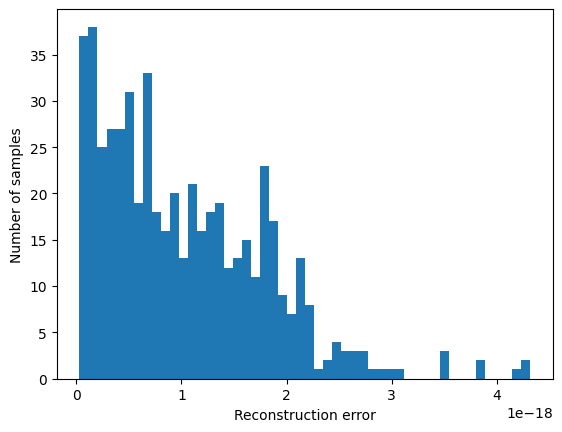

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.saving import register_keras_serializable

# Register custom layers
@register_keras_serializable(package='Custom')
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

@register_keras_serializable(package='Custom')
class CustomVariationalLayer(layers.Layer):
    def vae_loss(self, x, z_mean, z_log_var, x_decoded_mean):
        xent_loss = tf.keras.losses.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * tf.reduce_sum(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1, axis=-1)
        return tf.reduce_mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_mean = inputs[1]
        z_log_var = inputs[2]
        x_decoded_mean = inputs[3]
        loss = self.vae_loss(x, z_mean, z_log_var, x_decoded_mean)
        self.add_loss(loss)
        return x

# Function to build VAE model with custom Sampling layer
def build_vae(input_shape, latent_dim):
    inputs = layers.Input(shape=(input_shape,))

    # Encoder
    x = layers.Dense(128, activation='relu')(inputs)
    x = layers.Dense(64, activation='relu')(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)

    z = Sampling()([z_mean, z_log_var])

    # Decoder
    decoder_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(64, activation='relu')(decoder_inputs)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(input_shape, activation='sigmoid')(x)

    encoder = models.Model(inputs, [z_mean, z_log_var, z])
    decoder = models.Model(decoder_inputs, outputs)

    vae_outputs = decoder(encoder(inputs)[2])
    vae = models.Model(inputs, vae_outputs)

    # Custom loss layer for reconstruction loss
    custom_layer = CustomVariationalLayer()([inputs, z_mean, z_log_var, vae_outputs])

    vae = models.Model(inputs, custom_layer)
    vae.compile(optimizer='adam')

    return vae, encoder, decoder

# Load and preprocess the first dataset
data_file_1 = "Book1.xlsx"
df_1 = pd.read_excel(data_file_1, sheet_name="Sheet1", header=0)

if 'CodiceTipo' in df_1.columns:
    df_1['Target'] = df_1['CodiceTipo'].apply(lambda x: 1 if x == 6 else 0)
else:
    raise ValueError("'CodiceTipo' column not found in the dataset.")

df_1.rename(columns={
    'Codice': 'idAnomalia',
    'CodiceTipo': 'note',
    'DataOraRicezione': 'dataAnomalia',
    'Latitudine': 'latitudine',
    'Longitudine': 'longitudine',
    'DataOraRilevazione': 'dataCoordinate',
    'DataOraCreazione': 'dataSegnalazione',
    'Semirimorchio': 'idConcentratore'
}, inplace=True)

datetime_columns_1 = ['dataAnomalia', 'dataCoordinate', 'dataSegnalazione']
for col in datetime_columns_1:
    df_1[col] = pd.to_datetime(df_1[col], errors='coerce')
    df_1[col] = df_1[col].astype('int64') // 10**9

for col in datetime_columns_1:
    df_1[col] = df_1[col].fillna(df_1[col].median())

df_1['Autista'] = df_1['Autista'].astype(str)
df_1['CIM'] = df_1['CIM'].astype(str)
df_1['Valore'] = df_1['Valore'].astype(str)
df_1['Anteprima'] = df_1['Anteprima'].astype(str)

numeric_features_1 = df_1.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features_1 = df_1.select_dtypes(include=['object']).columns.tolist()

if 'Target' in numeric_features_1:
    numeric_features_1.remove('Target')
if 'Target' in categorical_features_1:
    categorical_features_1.remove('Target')

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features_1),
        ('cat', categorical_transformer, categorical_features_1)
    ]
)

X_1 = preprocessor.fit_transform(df_1.drop(columns=['Target']))
y_1 = df_1['Target']

print(f"Shape of X_1: {X_1.shape}")
print(f"Shape of y_1: {y_1.shape}")

# Build and train VAE on the first dataset
input_shape = X_1.shape[1]
latent_dim = 2
vae_additional, encoder_additional, decoder_additional = build_vae(input_shape, latent_dim)

history_additional = vae_additional.fit(X_1, X_1, epochs=200, batch_size=32, validation_split=0.2, verbose=1)

print(tf.__version__)

# Print model summary before saving
vae_additional.summary()

# Save the model without save_format argument
vae_additional.save('vae_additional.h5')

# Load the model
vae_additional = tf.keras.models.load_model(
    'vae_additional.h5',
    custom_objects={'Sampling': Sampling, 'CustomVariationalLayer': CustomVariationalLayer} # Provide custom objects for the loader
)

# Load and preprocess the current dataset
data_file = "Anomalies_2021_2024.xlsx"
df = pd.read_excel(data_file, sheet_name="Sheet1", header=0)

df['Target'] = df.apply(lambda row: 1 if pd.isnull(row['idPunto']) and row['note'] in [12, 6] else 0, axis=1)
df = df.drop(columns=['idPunto', 'note'])

datetime_columns = ['dataAnomalia', 'dataCoordinate', 'dataSegnalazione']
for col in datetime_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')
    df[col] = df[col].astype('int64') // 10**9

for col in datetime_columns:
    df[col].fillna(df[col].median(), inplace=True)

categorical_features = df.select_dtypes(include=['object']).columns
df[categorical_features] = df[categorical_features].astype(str)

X = df.drop(columns=['Target'])
y = df['Target']

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

X_preprocessed = preprocessor.fit_transform(X)

print(f"Shape of X_preprocessed: {X_preprocessed.shape}")
print(f"Shape of y: {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Build and fine-tune the VAE on the current dataset
vae, encoder, decoder = build_vae(X_preprocessed.shape[1], latent_dim)

# Fine-tune the VAE on the current dataset
history = vae.fit(X_train, X_train, epochs=200, batch_size=32, validation_split=0.2, verbose=1)

# Predict on the test set
X_test_pred = vae.predict(X_test)

# Calculate reconstruction error
reconstruction_loss = np.mean(np.square(X_test - X_test_pred), axis=1)

# Define a threshold for anomaly detection
threshold = np.percentile(reconstruction_loss, 80)
y_pred = (reconstruction_loss > threshold).astype(int)

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Visualize the reconstruction error
plt.hist(reconstruction_loss, bins=50)
plt.xlabel("Reconstruction error")
plt.ylabel("Number of samples")
plt.show()


Shape of X_1: (3425, 2455)
Shape of y_1: (3425,)
Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.4778 - val_loss: 0.0123
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0108 - val_loss: 0.0066
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0080 - val_loss: 0.0057
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0071 - val_loss: 0.0053
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0070 - val_loss: 0.0056
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0071 - val_loss: 0.0053
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0070 - val_loss: 0.0057
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0067 - val_loss: 0.0055
Epoch 9/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0065 - val_loss: 0.0053
Epoch 10/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0071 - val_loss: 0.0048
2.17.0


Model: "functional_136"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_76            │ (None, 2455)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_280 (Dense)         │ (None, 128)            │        314,368 │ input_layer_76[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_281 (Dense)         │ (None, 64)             │          8,256 │ dense_280[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_133            │ [(None, 2), (None, 2), │        322,884 │ input_layer_76[0][0]   │
│ (Functional)              │ (None, 2)]             │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_282 (Dense)         │ (None, 2)              │            130 │ dense_281[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_283 (Dense)         │ (None, 2)              │            130 │ dense_281[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_134            │ (None, 2455)           │        325,207 │ functional_133[0][2]   │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ custom_variational_layer… │ (None, 2455)           │              0 │ input_layer_76[0][0],  │
│ (CustomVariationalLayer)  │                        │                │ dense_282[0][0],       │
│                           │                        │                │ dense_283[0][0],       │
│                           │                        │                │ functional_134[0][0]   │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,944,275 (7.42 MB)

 Trainable params: 648,091 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,296,184 (4.94 MB)

Shape of X_preprocessed: (2670, 3304)
Shape of y: (2670,)
Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.5706 - val_loss: 0.0516
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0291 - val_loss: 0.0096
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0086 - val_loss: 0.0078
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0072 - val_loss: 0.0075
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0066 - val_loss: 0.0071
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0062 - val_loss: 0.0075
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0059 - val_loss: 0.0073
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0065 - val_loss: 0.0072
Epoch 9/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0065 - val_loss: 0.0073
Epoch 10/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0063 - val_loss: 0.0078
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Classification Report:
              precision    

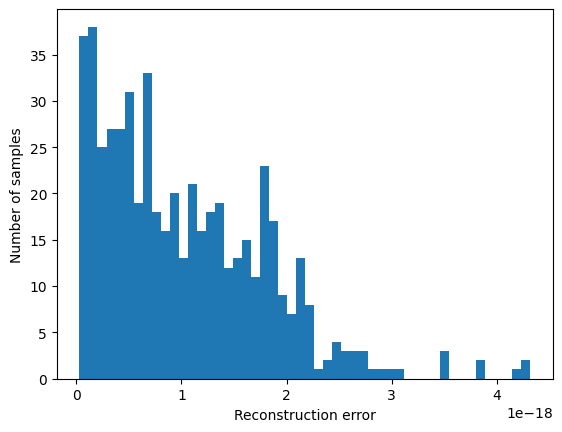

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.saving import register_keras_serializable

# Register custom layers
@register_keras_serializable(package='Custom')
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

@register_keras_serializable(package='Custom')
class CustomVariationalLayer(layers.Layer):
    def vae_loss(self, x, z_mean, z_log_var, x_decoded_mean):
        xent_loss = tf.keras.losses.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * tf.reduce_sum(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1, axis=-1)
        return tf.reduce_mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_mean = inputs[1]
        z_log_var = inputs[2]
        x_decoded_mean = inputs[3]
        loss = self.vae_loss(x, z_mean, z_log_var, x_decoded_mean)
        self.add_loss(loss)
        return x

# Function to build VAE model with custom Sampling layer
def build_vae(input_shape, latent_dim):
    inputs = layers.Input(shape=(input_shape,))

    # Encoder
    x = layers.Dense(128, activation='relu')(inputs)
    x = layers.Dense(64, activation='relu')(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)

    z = Sampling()([z_mean, z_log_var])

    # Decoder
    decoder_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(64, activation='relu')(decoder_inputs)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(input_shape, activation='sigmoid')(x)

    encoder = models.Model(inputs, [z_mean, z_log_var, z])
    decoder = models.Model(decoder_inputs, outputs)

    vae_outputs = decoder(encoder(inputs)[2])
    vae = models.Model(inputs, vae_outputs)

    # Custom loss layer for reconstruction loss
    custom_layer = CustomVariationalLayer()([inputs, z_mean, z_log_var, vae_outputs])

    vae = models.Model(inputs, custom_layer)
    vae.compile(optimizer='adam')

    return vae, encoder, decoder

# Load and preprocess the first dataset
data_file_1 = "Book1.xlsx"
df_1 = pd.read_excel(data_file_1, sheet_name="Sheet1", header=0)

if 'CodiceTipo' in df_1.columns:
    df_1['Target'] = df_1['CodiceTipo'].apply(lambda x: 1 if x == 6 else 0)
else:
    raise ValueError("'CodiceTipo' column not found in the dataset.")

df_1.rename(columns={
    'Codice': 'idAnomalia',
    'CodiceTipo': 'note',
    'DataOraRicezione': 'dataAnomalia',
    'Latitudine': 'latitudine',
    'Longitudine': 'longitudine',
    'DataOraRilevazione': 'dataCoordinate',
    'DataOraCreazione': 'dataSegnalazione',
    'Semirimorchio': 'idConcentratore'
}, inplace=True)

datetime_columns_1 = ['dataAnomalia', 'dataCoordinate', 'dataSegnalazione']
for col in datetime_columns_1:
    df_1[col] = pd.to_datetime(df_1[col], errors='coerce')
    df_1[col] = df_1[col].astype('int64') // 10**9

for col in datetime_columns_1:
    df_1[col] = df_1[col].fillna(df_1[col].median())

df_1['Autista'] = df_1['Autista'].astype(str)
df_1['CIM'] = df_1['CIM'].astype(str)
df_1['Valore'] = df_1['Valore'].astype(str)
df_1['Anteprima'] = df_1['Anteprima'].astype(str)

numeric_features_1 = df_1.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features_1 = df_1.select_dtypes(include=['object']).columns.tolist()

if 'Target' in numeric_features_1:
    numeric_features_1.remove('Target')
if 'Target' in categorical_features_1:
    categorical_features_1.remove('Target')

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features_1),
        ('cat', categorical_transformer, categorical_features_1)
    ]
)

X_1 = preprocessor.fit_transform(df_1.drop(columns=['Target']))
y_1 = df_1['Target']

print(f"Shape of X_1: {X_1.shape}")
print(f"Shape of y_1: {y_1.shape}")

# Build and train VAE on the first dataset
input_shape = X_1.shape[1]
latent_dim = 2
vae_additional, encoder_additional, decoder_additional = build_vae(input_shape, latent_dim)

history_additional = vae_additional.fit(X_1, X_1, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

print(tf.__version__)

# Print model summary before saving
vae_additional.summary()

# Save the model in h5 format
vae_additional.save('vae_additional.h5')

# Load the model with custom objects
vae_additional = tf.keras.models.load_model(
    'vae_additional.h5',
    custom_objects={'Sampling': Sampling, 'CustomVariationalLayer': CustomVariationalLayer} # Provide custom objects for the loader
)

# Load and preprocess the current dataset
data_file = "Anomalies_2021_2024.xlsx"
df = pd.read_excel(data_file, sheet_name="Sheet1", header=0)

df['Target'] = df.apply(lambda row: 1 if pd.isnull(row['idPunto']) and row['note'] in [12, 6] else 0, axis=1)
df = df.drop(columns=['idPunto', 'note'])

datetime_columns = ['dataAnomalia', 'dataCoordinate', 'dataSegnalazione']
for col in datetime_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')
    df[col] = df[col].astype('int64') // 10**9

for col in datetime_columns:
    df[col].fillna(df[col].median(), inplace=True)

categorical_features = df.select_dtypes(include=['object']).columns
df[categorical_features] = df[categorical_features].astype(str)

X = df.drop(columns=['Target'])
y = df['Target']

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

X_preprocessed = preprocessor.fit_transform(X)

print(f"Shape of X_preprocessed: {X_preprocessed.shape}")
print(f"Shape of y: {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Build and fine-tune the VAE on the current dataset
vae, encoder, decoder = build_vae(X_preprocessed.shape[1], latent_dim)

# Fine-tune the VAE on the current dataset
history = vae.fit(X_train, X_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Predict on the test set
X_test_pred = vae.predict(X_test)

# Calculate reconstruction error
reconstruction_loss = np.mean(np.square(X_test - X_test_pred), axis=1)

# Define a threshold for anomaly detection
threshold = np.percentile(reconstruction_loss, 80)
y_pred = (reconstruction_loss > threshold).astype(int)

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Visualize the reconstruction error
plt.hist(reconstruction_loss, bins=50)
plt.xlabel("Reconstruction error")
plt.ylabel("Number of samples")
plt.show()


## **Perpjekje per optimizim kodin e ri pas update**

Shape of X_1: (3425, 2455)
Shape of y_1: (3425,)
Epoch 1/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 4.7328 - val_loss: 0.7556 - learning_rate: 0.0010
Epoch 2/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 1.6525 - val_loss: 0.3777 - learning_rate: 0.0010
Epoch 3/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 1.0602 - val_loss: 0.2302 - learning_rate: 0.0010
Epoch 4/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.7400 - val_loss: 0.1679 - learning_rate: 0.0010
Epoch 5/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.5768 - val_loss: 0.1114 - learning_rate: 0.0010
Epoch 6/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.4649 - val_loss: 0.1466 - learning_rate: 0.0010
Epoch 7/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.3778 - val_loss: 0.1025 - learning_rate: 0.0010
Epoch 8/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.2863 - val_loss: 0.0704 - learning_rate: 0.0010
Epoch 9/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.2496 - va

Shape of X_preprocessed: (2670, 3304)
Shape of y: (2670,)
Epoch 1/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 4.3789 - val_loss: 0.9935 - learning_rate: 0.0010
Epoch 2/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 2.1266 - val_loss: 0.6916 - learning_rate: 0.0010
Epoch 3/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 1.3672 - val_loss: 0.3464 - learning_rate: 0.0010
Epoch 4/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.9305 - val_loss: 0.2037 - learning_rate: 0.0010
Epoch 5/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.7356 - val_loss: 0.1324 - learning_rate: 0.0010
Epoch 6/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.5909 - val_loss: 0.1005 - learning_rate: 0.0010
Epoch 7/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.4661 - val_loss: 0.0906 - learning_rate: 0.0010
Epoch 8/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.4180 - val_loss: 0.0691 - learning_rate: 0.0010
Epoch 9/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.

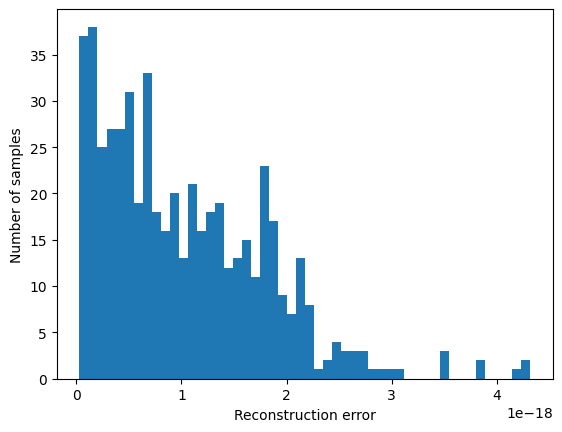

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Register custom layers
@register_keras_serializable(package='Custom')
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

@register_keras_serializable(package='Custom')
class CustomVariationalLayer(layers.Layer):
    def vae_loss(self, x, z_mean, z_log_var, x_decoded_mean):
        xent_loss = tf.keras.losses.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * tf.reduce_sum(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1, axis=-1)
        return tf.reduce_mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_mean = inputs[1]
        z_log_var = inputs[2]
        x_decoded_mean = inputs[3]
        loss = self.vae_loss(x, z_mean, z_log_var, x_decoded_mean)
        self.add_loss(loss)
        return x

# Function to build VAE model with custom Sampling layer
def build_vae(input_shape, latent_dim):
    inputs = layers.Input(shape=(input_shape,))

    # Encoder
    x = layers.Dense(256, activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)

    z = Sampling()([z_mean, z_log_var])

    # Decoder
    decoder_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(128, activation='relu')(decoder_inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(input_shape, activation='sigmoid')(x)

    encoder = models.Model(inputs, [z_mean, z_log_var, z])
    decoder = models.Model(decoder_inputs, outputs)

    vae_outputs = decoder(encoder(inputs)[2])
    vae = models.Model(inputs, vae_outputs)

    # Custom loss layer for reconstruction loss
    custom_layer = CustomVariationalLayer()([inputs, z_mean, z_log_var, vae_outputs])

    vae = models.Model(inputs, custom_layer)
    vae.compile(optimizer='adam')

    return vae, encoder, decoder

# Load and preprocess the first dataset
data_file_1 = "Book1.xlsx"
df_1 = pd.read_excel(data_file_1, sheet_name="Sheet1", header=0)

if 'CodiceTipo' in df_1.columns:
    df_1['Target'] = df_1['CodiceTipo'].apply(lambda x: 1 if x == 6 else 0)
else:
    raise ValueError("'CodiceTipo' column not found in the dataset.")

df_1.rename(columns={
    'Codice': 'idAnomalia',
    'CodiceTipo': 'note',
    'DataOraRicezione': 'dataAnomalia',
    'Latitudine': 'latitudine',
    'Longitudine': 'longitudine',
    'DataOraRilevazione': 'dataCoordinate',
    'DataOraCreazione': 'dataSegnalazione',
    'Semirimorchio': 'idConcentratore'
}, inplace=True)

datetime_columns_1 = ['dataAnomalia', 'dataCoordinate', 'dataSegnalazione']
for col in datetime_columns_1:
    df_1[col] = pd.to_datetime(df_1[col], errors='coerce')
    df_1[col] = df_1[col].astype('int64') // 10**9

for col in datetime_columns_1:
    df_1[col] = df_1[col].fillna(df_1[col].median())

df_1['Autista'] = df_1['Autista'].astype(str)
df_1['CIM'] = df_1['CIM'].astype(str)
df_1['Valore'] = df_1['Valore'].astype(str)
df_1['Anteprima'] = df_1['Anteprima'].astype(str)

numeric_features_1 = df_1.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features_1 = df_1.select_dtypes(include=['object']).columns.tolist()

if 'Target' in numeric_features_1:
    numeric_features_1.remove('Target')
if 'Target' in categorical_features_1:
    categorical_features_1.remove('Target')

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features_1),
        ('cat', categorical_transformer, categorical_features_1)
    ]
)

X_1 = preprocessor.fit_transform(df_1.drop(columns=['Target']))
y_1 = df_1['Target']

print(f"Shape of X_1: {X_1.shape}")
print(f"Shape of y_1: {y_1.shape}")

# Build and train VAE on the first dataset
input_shape = X_1.shape[1]
latent_dim = 2
vae_additional, encoder_additional, decoder_additional = build_vae(input_shape, latent_dim)

history_additional = vae_additional.fit(X_1, X_1, epochs=200, batch_size=32, validation_split=0.2, verbose=1, callbacks=[
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
])

# Save the model without save_format argument
vae_additional.save('vae_additional.h5')

# Load the model
vae_additional = tf.keras.models.load_model(
    'vae_additional.h5',
    custom_objects={'Sampling': Sampling, 'CustomVariationalLayer': CustomVariationalLayer} # Provide custom objects for the loader
)

# Load and preprocess the current dataset
data_file = "Anomalies_2021_2024.xlsx"
df = pd.read_excel(data_file, sheet_name="Sheet1", header=0)

df['Target'] = df.apply(lambda row: 1 if pd.isnull(row['idPunto']) and row['note'] in [12, 6] else 0, axis=1)
df = df.drop(columns=['idPunto', 'note'])

datetime_columns = ['dataAnomalia', 'dataCoordinate', 'dataSegnalazione']
for col in datetime_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')
    df[col] = df[col].astype('int64') // 10**9

for col in datetime_columns:
    df[col].fillna(df[col].median(), inplace=True)

categorical_features = df.select_dtypes(include=['object']).columns
df[categorical_features] = df[categorical_features].astype(str)

X = df.drop(columns=['Target'])
y = df['Target']

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

X_preprocessed = preprocessor.fit_transform(X)

print(f"Shape of X_preprocessed: {X_preprocessed.shape}")
print(f"Shape of y: {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Build and fine-tune the VAE on the current dataset
vae, encoder, decoder = build_vae(X_preprocessed.shape[1], latent_dim)

# Fine-tune the VAE on the current dataset
history = vae.fit(X_train, X_train, epochs=200, batch_size=32, validation_split=0.2, verbose=1, callbacks=[
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
])

# Predict on the test set
X_test_pred = vae.predict(X_test)

# Calculate reconstruction error
reconstruction_loss = np.mean(np.square(X_test - X_test_pred), axis=1)

# Define a threshold for anomaly detection
threshold = np.percentile(reconstruction_loss, 80)
y_pred = (reconstruction_loss > threshold).astype(int)

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Visualize the reconstruction error
plt.hist(reconstruction_loss, bins=50)
plt.xlabel("Reconstruction error")
plt.ylabel("Number of samples")
plt.show()


## **Duke u perpjekur t'i rregullojme performancen ketij updated**

Shape of X_1: (3425, 2455)
Shape of y_1: (3425,)
Epoch 1/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 0.3901 - val_loss: 0.0065
Epoch 2/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0083 - val_loss: 0.0057
Epoch 3/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0073 - val_loss: 0.0053
Epoch 4/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0073 - val_loss: 0.0054
Epoch 5/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0070 - val_loss: 0.0056
Epoch 6/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0069 - val_loss: 0.0059
Epoch 7/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0070 - val_loss: 0.0064
Epoch 8/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0070 - val_loss: 0.0050
Epoch 9/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0068 - val_loss: 0.0050
Epoch 10/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0067 - val_loss: 0.0053
Epoch 11/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0069 - val_loss: 0.0056
Epo

Model: "functional_180"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_98            │ (None, 2455)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_357 (Dense)         │ (None, 256)            │        628,736 │ input_layer_98[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_358 (Dense)         │ (None, 128)            │         32,896 │ dense_357[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_177            │ [(None, 2), (None, 2), │        662,148 │ input_layer_98[0][0]   │
│ (Functional)              │ (None, 2)]             │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_359 (Dense)         │ (None, 2)              │            258 │ dense_358[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_360 (Dense)         │ (None, 2)              │            258 │ dense_358[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_178            │ (None, 2455)           │        664,343 │ functional_177[0][2]   │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ custom_variational_layer… │ (None, 2455)           │              0 │ input_layer_98[0][0],  │
│ (CustomVariationalLayer)  │                        │                │ dense_359[0][0],       │
│                           │                        │                │ dense_360[0][0],       │
│                           │                        │                │ functional_178[0][0]   │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,979,475 (15.18 MB)

 Trainable params: 1,326,491 (5.06 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,652,984 (10.12 MB)

Shape of X_preprocessed: (2670, 3304)
Shape of y: (2670,)
Epoch 1/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.5059 - val_loss: 0.0128
Epoch 2/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0095 - val_loss: 0.0078
Epoch 3/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0070 - val_loss: 0.0075
Epoch 4/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0067 - val_loss: 0.0076
Epoch 5/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0067 - val_loss: 0.0073
Epoch 6/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0065 - val_loss: 0.0075
Epoch 7/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0063 - val_loss: 0.0079
Epoch 8/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.0059 - val_loss: 0.0080
Epoch 9/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 0.0058 - val_loss: 0.0075
Epoch 10/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0057 - val_loss: 0.0077
Epoch 11/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 0.0058 - val_loss: 0

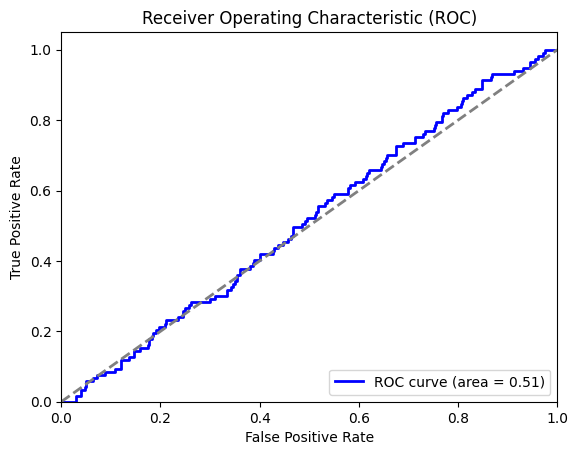

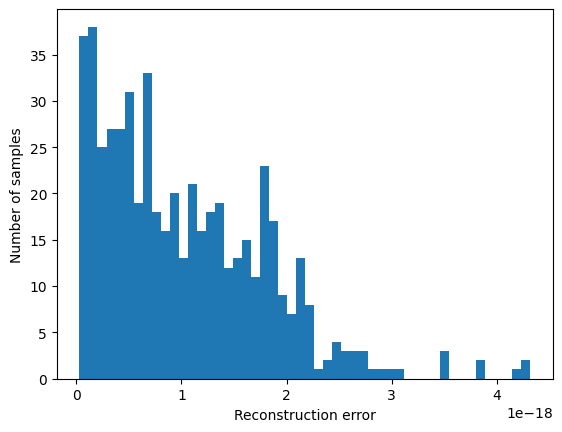

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.saving import register_keras_serializable

# Register custom layers
@register_keras_serializable(package='Custom')
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

@register_keras_serializable(package='Custom')
class CustomVariationalLayer(layers.Layer):
    def vae_loss(self, x, z_mean, z_log_var, x_decoded_mean):
        xent_loss = tf.keras.losses.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * tf.reduce_sum(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1, axis=-1)
        return tf.reduce_mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_mean = inputs[1]
        z_log_var = inputs[2]
        x_decoded_mean = inputs[3]
        loss = self.vae_loss(x, z_mean, z_log_var, x_decoded_mean)
        self.add_loss(loss)
        return x

# Function to build VAE model with custom Sampling layer
def build_vae(input_shape, latent_dim):
    inputs = layers.Input(shape=(input_shape,))

    # Encoder
    x = layers.Dense(256, activation='relu')(inputs)
    x = layers.Dense(128, activation='relu')(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)

    z = Sampling()([z_mean, z_log_var])

    # Decoder
    decoder_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(128, activation='relu')(decoder_inputs)
    x = layers.Dense(256, activation='relu')(x)
    outputs = layers.Dense(input_shape, activation='sigmoid')(x)

    encoder = models.Model(inputs, [z_mean, z_log_var, z])
    decoder = models.Model(decoder_inputs, outputs)

    vae_outputs = decoder(encoder(inputs)[2])
    vae = models.Model(inputs, vae_outputs)

    # Custom loss layer for reconstruction loss
    custom_layer = CustomVariationalLayer()([inputs, z_mean, z_log_var, vae_outputs])

    vae = models.Model(inputs, custom_layer)
    vae.compile(optimizer='adam')

    return vae, encoder, decoder

# Load and preprocess the first dataset
data_file_1 = "Book1.xlsx"
df_1 = pd.read_excel(data_file_1, sheet_name="Sheet1", header=0)

if 'CodiceTipo' in df_1.columns:
    df_1['Target'] = df_1['CodiceTipo'].apply(lambda x: 1 if x == 6 else 0)
else:
    raise ValueError("'CodiceTipo' column not found in the dataset.")

df_1.rename(columns={
    'Codice': 'idAnomalia',
    'CodiceTipo': 'note',
    'DataOraRicezione': 'dataAnomalia',
    'Latitudine': 'latitudine',
    'Longitudine': 'longitudine',
    'DataOraRilevazione': 'dataCoordinate',
    'DataOraCreazione': 'dataSegnalazione',
    'Semirimorchio': 'idConcentratore'
}, inplace=True)

datetime_columns_1 = ['dataAnomalia', 'dataCoordinate', 'dataSegnalazione']
for col in datetime_columns_1:
    df_1[col] = pd.to_datetime(df_1[col], errors='coerce')
    df_1[col] = df_1[col].astype('int64') // 10**9

for col in datetime_columns_1:
    df_1[col] = df_1[col].fillna(df_1[col].median())

df_1['Autista'] = df_1['Autista'].astype(str)
df_1['CIM'] = df_1['CIM'].astype(str)
df_1['Valore'] = df_1['Valore'].astype(str)
df_1['Anteprima'] = df_1['Anteprima'].astype(str)

numeric_features_1 = df_1.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features_1 = df_1.select_dtypes(include=['object']).columns.tolist()

if 'Target' in numeric_features_1:
    numeric_features_1.remove('Target')
if 'Target' in categorical_features_1:
    categorical_features_1.remove('Target')

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features_1),
        ('cat', categorical_transformer, categorical_features_1)
    ]
)

X_1 = preprocessor.fit_transform(df_1.drop(columns=['Target']))
y_1 = df_1['Target']

print(f"Shape of X_1: {X_1.shape}")
print(f"Shape of y_1: {y_1.shape}")

# Build and train VAE on the first dataset
input_shape = X_1.shape[1]
latent_dim = 2
vae_additional, encoder_additional, decoder_additional = build_vae(input_shape, latent_dim)

history_additional = vae_additional.fit(X_1, X_1, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

print(tf.__version__)

# Print model summary before saving
vae_additional.summary()

# Save the model without save_format argument
vae_additional.save('vae_additional.h5')

# Load the model
vae_additional = tf.keras.models.load_model(
    'vae_additional.h5',
    custom_objects={'Sampling': Sampling, 'CustomVariationalLayer': CustomVariationalLayer} # Provide custom objects for the loader
)

# Load and preprocess the current dataset
data_file = "Anomalies_2021_2024.xlsx"
df = pd.read_excel(data_file, sheet_name="Sheet1", header=0)

df['Target'] = df.apply(lambda row: 1 if pd.isnull(row['idPunto']) and row['note'] in [12, 6] else 0, axis=1)
df = df.drop(columns=['idPunto', 'note'])

datetime_columns = ['dataAnomalia', 'dataCoordinate', 'dataSegnalazione']
for col in datetime_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')
    df[col] = df[col].astype('int64') // 10**9

for col in datetime_columns:
    df[col].fillna(df[col].median(), inplace=True)

categorical_features = df.select_dtypes(include=['object']).columns
df[categorical_features] = df[categorical_features].astype(str)

X = df.drop(columns=['Target'])
y = df['Target']

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

X_preprocessed = preprocessor.fit_transform(X)

print(f"Shape of X_preprocessed: {X_preprocessed.shape}")
print(f"Shape of y: {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Build and fine-tune the VAE on the current dataset
vae, encoder, decoder = build_vae(X_preprocessed.shape[1], latent_dim)

# Fine-tune the VAE on the current dataset
history = vae.fit(X_train, X_train, epochs=200, batch_size=32, validation_split=0.2, verbose=1)

# Predict on the test set
X_test_pred = vae.predict(X_test)

# Calculate reconstruction error
reconstruction_loss = np.mean(np.square(X_test - X_test_pred), axis=1)

# Define a threshold for anomaly detection
threshold = np.percentile(reconstruction_loss, 85)
y_pred = (reconstruction_loss > threshold).astype(int)

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot ROC Curve and calculate AUC
fpr, tpr, _ = roc_curve(y_test, reconstruction_loss)
roc_auc = roc_auc_score(y_test, reconstruction_loss)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Visualize the reconstruction error
plt.hist(reconstruction_loss, bins=50)
plt.xlabel("Reconstruction error")
plt.ylabel("Number of samples")
plt.show()


### Po ndryshojme prap metrikat

Shape of X_1: (3425, 2455)
Shape of y_1: (3425,)
Epoch 1/400
172/172 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - loss: 3.3138 - val_loss: 0.3371 - learning_rate: 0.0010
Epoch 2/400
172/172 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.9647 - val_loss: 0.1081 - learning_rate: 0.0010
Epoch 3/400
172/172 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.5453 - val_loss: 0.0582 - learning_rate: 0.0010
Epoch 4/400
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.2961 - val_loss: 0.0317 - learning_rate: 0.0010
Epoch 5/400
172/172 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.1806 - val_loss: 0.0193 - learning_rate: 0.0010
Epoch 6/400
172/172 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.1081 - val_loss: 0.0117 - learning_rate: 0.0010
Epoch 7/400
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0717 - val_loss: 0.0092 - learning_rate: 0.0010
Epoch 8/400
172/172 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.0424 - val_loss: 0.0065 - learning_rate: 0.0010
Epoch 9/400
172/172 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step 

Shape of X_preprocessed: (2670, 3304)
Shape of y: (2670,)
Epoch 1/400
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 3.8191 - val_loss: 0.4557 - learning_rate: 0.0010
Epoch 2/400
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 1.5179 - val_loss: 0.1150 - learning_rate: 0.0010
Epoch 3/400
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.8437 - val_loss: 0.0973 - learning_rate: 0.0010
Epoch 4/400
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.5892 - val_loss: 0.0771 - learning_rate: 0.0010
Epoch 5/400
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.4123 - val_loss: 0.0535 - learning_rate: 0.0010
Epoch 6/400
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.3214 - val_loss: 0.0418 - learning_rate: 0.0010
Epoch 7/400
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.2333 - val_loss: 0.0293 - learning_rate: 0.0010
Epoch 8/400
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.1750 - val_loss: 0.0265 - learning_rate: 0.0010
Epoch 9/400
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 24

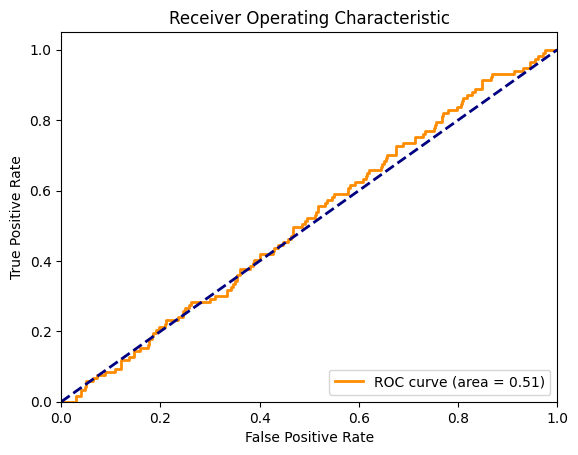

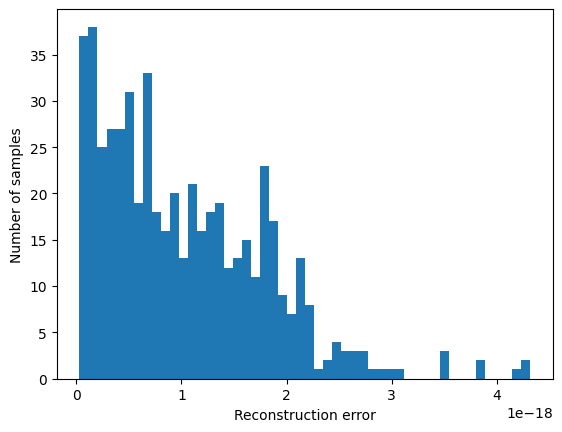

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_curve, auc
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Register custom layers
@register_keras_serializable(package='Custom')
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

@register_keras_serializable(package='Custom')
class CustomVariationalLayer(layers.Layer):
    def vae_loss(self, x, z_mean, z_log_var, x_decoded_mean):
        xent_loss = tf.keras.losses.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * tf.reduce_sum(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1, axis=-1)
        return tf.reduce_mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_mean = inputs[1]
        z_log_var = inputs[2]
        x_decoded_mean = inputs[3]
        loss = self.vae_loss(x, z_mean, z_log_var, x_decoded_mean)
        self.add_loss(loss)
        return x

# Function to build VAE model with custom Sampling layer
def build_vae(input_shape, latent_dim):
    inputs = layers.Input(shape=(input_shape,))

    # Encoder
    x = layers.Dense(256, activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)

    z = Sampling()([z_mean, z_log_var])

    # Decoder
    decoder_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(128, activation='relu')(decoder_inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(input_shape, activation='sigmoid')(x)

    encoder = models.Model(inputs, [z_mean, z_log_var, z])
    decoder = models.Model(decoder_inputs, outputs)

    vae_outputs = decoder(encoder(inputs)[2])
    vae = models.Model(inputs, vae_outputs)

    # Custom loss layer for reconstruction loss
    custom_layer = CustomVariationalLayer()([inputs, z_mean, z_log_var, vae_outputs])

    vae = models.Model(inputs, custom_layer)
    vae.compile(optimizer='adam')

    return vae, encoder, decoder

# Load and preprocess the first dataset
data_file_1 = "Book1.xlsx"
df_1 = pd.read_excel(data_file_1, sheet_name="Sheet1", header=0)

if 'CodiceTipo' in df_1.columns:
    df_1['Target'] = df_1['CodiceTipo'].apply(lambda x: 1 if x == 6 else 0)
else:
    raise ValueError("'CodiceTipo' column not found in the dataset.")

df_1.rename(columns={
    'Codice': 'idAnomalia',
    'CodiceTipo': 'note',
    'DataOraRicezione': 'dataAnomalia',
    'Latitudine': 'latitudine',
    'Longitudine': 'longitudine',
    'DataOraRilevazione': 'dataCoordinate',
    'DataOraCreazione': 'dataSegnalazione',
    'Semirimorchio': 'idConcentratore'
}, inplace=True)

datetime_columns_1 = ['dataAnomalia', 'dataCoordinate', 'dataSegnalazione']
for col in datetime_columns_1:
    df_1[col] = pd.to_datetime(df_1[col], errors='coerce')
    df_1[col] = df_1[col].astype('int64') // 10**9

for col in datetime_columns_1:
    df_1[col] = df_1[col].fillna(df_1[col].median())

df_1['Autista'] = df_1['Autista'].astype(str)
df_1['CIM'] = df_1['CIM'].astype(str)
df_1['Valore'] = df_1['Valore'].astype(str)
df_1['Anteprima'] = df_1['Anteprima'].astype(str)

numeric_features_1 = df_1.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features_1 = df_1.select_dtypes(include=['object']).columns.tolist()

if 'Target' in numeric_features_1:
    numeric_features_1.remove('Target')
if 'Target' in categorical_features_1:
    categorical_features_1.remove('Target')

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features_1),
        ('cat', categorical_transformer, categorical_features_1)
    ]
)

X_1 = preprocessor.fit_transform(df_1.drop(columns=['Target']))
y_1 = df_1['Target']

print(f"Shape of X_1: {X_1.shape}")
print(f"Shape of y_1: {y_1.shape}")

# Build and train VAE on the first dataset
input_shape = X_1.shape[1]
latent_dim = 2
vae_additional, encoder_additional, decoder_additional = build_vae(input_shape, latent_dim)

history_additional = vae_additional.fit(X_1, X_1, epochs=400, batch_size=16, validation_split=0.2, verbose=1, callbacks=[
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
])

# Save the model without save_format argument
vae_additional.save('vae_additional.h5')

# Load the model
vae_additional = tf.keras.models.load_model(
    'vae_additional.h5',
    custom_objects={'Sampling': Sampling, 'CustomVariationalLayer': CustomVariationalLayer} # Provide custom objects for the loader
)

# Load and preprocess the current dataset
data_file = "Anomalies_2021_2024.xlsx"
df = pd.read_excel(data_file, sheet_name="Sheet1", header=0)

df['Target'] = df.apply(lambda row: 1 if pd.isnull(row['idPunto']) and row['note'] in [12, 6] else 0, axis=1)
df = df.drop(columns=['idPunto', 'note'])

datetime_columns = ['dataAnomalia', 'dataCoordinate', 'dataSegnalazione']
for col in datetime_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')
    df[col] = df[col].astype('int64') // 10**9

for col in datetime_columns:
    df[col].fillna(df[col].median(), inplace=True)

categorical_features = df.select_dtypes(include=['object']).columns
df[categorical_features] = df[categorical_features].astype(str)

X = df.drop(columns=['Target'])
y = df['Target']

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

X_preprocessed = preprocessor.fit_transform(X)

print(f"Shape of X_preprocessed: {X_preprocessed.shape}")
print(f"Shape of y: {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Build and fine-tune the VAE on the current dataset
vae, encoder, decoder = build_vae(X_preprocessed.shape[1], latent_dim)

# Fine-tune the VAE on the current dataset
history = vae.fit(X_train, X_train, epochs=400, batch_size=16, validation_split=0.2, verbose=1, callbacks=[
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
])

# Predict on the test set
X_test_pred = vae.predict(X_test)

# Calculate reconstruction error
reconstruction_loss = np.mean(np.square(X_test - X_test_pred), axis=1)

# ROC curve analysis
fpr, tpr, thresholds = roc_curve(y_test, reconstruction_loss)
roc_auc = auc(fpr, tpr)

# Find the optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Define a threshold for anomaly detection
y_pred_optimal = (reconstruction_loss > optimal_threshold).astype(int)

# Print the classification report
print(f"\nOptimal threshold: {optimal_threshold}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_optimal))

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Visualize the reconstruction error
plt.hist(reconstruction_loss, bins=50)
plt.xlabel("Reconstruction error")
plt.ylabel("Number of samples")
plt.show()


### Posupozojme te bejme prap TL

Shape of X_1: (3425, 2455)
Shape of y_1: (3425,)
Epoch 1/400
172/172 ━━━━━━━━━━━━━━━━━━━━ 26s 68ms/step - loss: 16.8371 - val_loss: 1.1576 - learning_rate: 0.0010
Epoch 2/400
172/172 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - loss: 4.9930 - val_loss: 0.6509 - learning_rate: 0.0010
Epoch 3/400
172/172 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 2.9121 - val_loss: 0.4224 - learning_rate: 0.0010
Epoch 4/400
172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 1.9587 - val_loss: 0.3107 - learning_rate: 0.0010
Epoch 5/400
172/172 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 1.3155 - val_loss: 0.1968 - learning_rate: 0.0010
Epoch 6/400
172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - loss: 0.9814 - val_loss: 0.1420 - learning_rate: 0.0010
Epoch 7/400
172/172 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - loss: 0.7488 - val_loss: 0.0918 - learning_rate: 0.0010
Epoch 8/400
172/172 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.5542 - val_loss: 0.0778 - learning_rate: 0.0010
Epoch 9/400
172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/

Shape of X_preprocessed: (2670, 3304)
Shape of y: (2670,)
Epoch 1/400
168/168 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - loss: 14.8898 - val_loss: 1.0394 - learning_rate: 0.0010
Epoch 2/400
168/168 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 4.4025 - val_loss: 0.3622 - learning_rate: 0.0010
Epoch 3/400
168/168 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - loss: 2.5901 - val_loss: 0.2436 - learning_rate: 0.0010
Epoch 4/400
168/168 ━━━━━━━━━━━━━━━━━━━━ 12s 57ms/step - loss: 1.6139 - val_loss: 0.1523 - learning_rate: 0.0010
Epoch 5/400
168/168 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 1.0756 - val_loss: 0.0891 - learning_rate: 0.0010
Epoch 6/400
168/168 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 0.7350 - val_loss: 0.0642 - learning_rate: 0.0010
Epoch 7/400
168/168 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - loss: 0.5155 - val_loss: 0.0439 - learning_rate: 0.0010
Epoch 8/400
168/168 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - loss: 0.3702 - val_loss: 0.0327 - learning_rate: 0.0010
Epoch 9/400
168/168 ━━━━━━━━━━━━━━━━━━━━

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Optimal threshold: 2.0074866330328059e-19
              precision    recall  f1-score   support

           0       0.85      0.15      0.26       417
           1       0.23      0.91      0.37       117

    accuracy                           0.32       534
   macro avg       0.54      0.53      0.31       534
weighted avg       0.72      0.32      0.28       534

ROC AUC: 0.5146241980774354


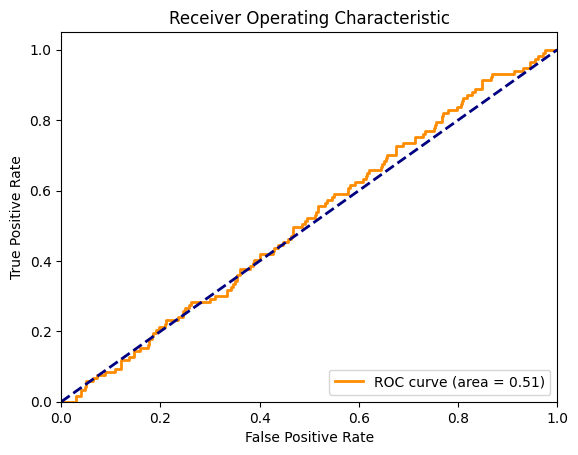

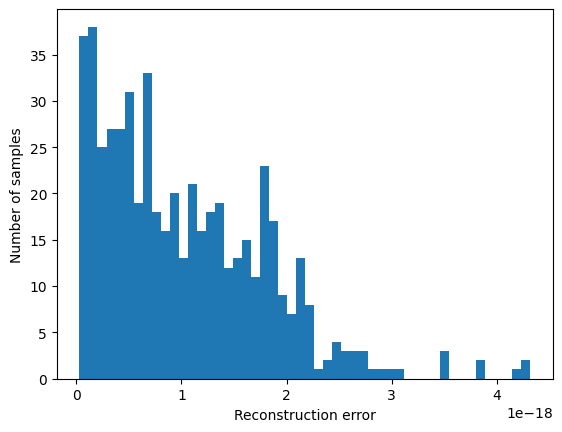

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_curve, auc
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Register custom layers
@register_keras_serializable(package='Custom')
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

@register_keras_serializable(package='Custom')
class CustomVariationalLayer(layers.Layer):
    def vae_loss(self, x, z_mean, z_log_var, x_decoded_mean):
        xent_loss = tf.keras.losses.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * tf.reduce_sum(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1, axis=-1)
        return tf.reduce_mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_mean = inputs[1]
        z_log_var = inputs[2]
        x_decoded_mean = inputs[3]
        loss = self.vae_loss(x, z_mean, z_log_var, x_decoded_mean)
        self.add_loss(loss)
        return x

# Function to build VAE model with custom Sampling layer
def build_vae(input_shape, latent_dim):
    inputs = layers.Input(shape=(input_shape,))

    # Encoder
    x = layers.Dense(512, activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)

    z = Sampling()([z_mean, z_log_var])

    # Decoder
    decoder_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(256, activation='relu')(decoder_inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(input_shape, activation='sigmoid')(x)

    encoder = models.Model(inputs, [z_mean, z_log_var, z])
    decoder = models.Model(decoder_inputs, outputs)

    vae_outputs = decoder(encoder(inputs)[2])
    vae = models.Model(inputs, vae_outputs)

    custom_layer = CustomVariationalLayer()([inputs, z_mean, z_log_var, vae_outputs])

    vae = models.Model(inputs, custom_layer)
    vae.compile(optimizer='adam')

    return vae, encoder, decoder

# Load and preprocess the first dataset
data_file_1 = "Book1.xlsx"
df_1 = pd.read_excel(data_file_1, sheet_name="Sheet1", header=0)

if 'CodiceTipo' in df_1.columns:
    df_1['Target'] = df_1['CodiceTipo'].apply(lambda x: 1 if x == 6 else 0)
else:
    raise ValueError("'CodiceTipo' column not found in the dataset.")

df_1.rename(columns={
    'Codice': 'idAnomalia',
    'CodiceTipo': 'note',
    'DataOraRicezione': 'dataAnomalia',
    'Latitudine': 'latitudine',
    'Longitudine': 'longitudine',
    'DataOraRilevazione': 'dataCoordinate',
    'DataOraCreazione': 'dataSegnalazione',
    'Semirimorchio': 'idConcentratore'
}, inplace=True)

datetime_columns_1 = ['dataAnomalia', 'dataCoordinate', 'dataSegnalazione']
for col in datetime_columns_1:
    df_1[col] = pd.to_datetime(df_1[col], errors='coerce')
    df_1[col] = df_1[col].astype('int64') // 10**9

for col in datetime_columns_1:
    df_1[col] = df_1[col].fillna(df_1[col].median())

df_1['Autista'] = df_1['Autista'].astype(str)
df_1['CIM'] = df_1['CIM'].astype(str)
df_1['Valore'] = df_1['Valore'].astype(str)
df_1['Anteprima'] = df_1['Anteprima'].astype(str)

numeric_features_1 = df_1.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features_1 = df_1.select_dtypes(include=['object']).columns.tolist()

if 'Target' in numeric_features_1:
    numeric_features_1.remove('Target')
if 'Target' in categorical_features_1:
    categorical_features_1.remove('Target')

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features_1),
        ('cat', categorical_transformer, categorical_features_1)
    ]
)

X_1 = preprocessor.fit_transform(df_1.drop(columns=['Target']))
y_1 = df_1['Target']

print(f"Shape of X_1: {X_1.shape}")
print(f"Shape of y_1: {y_1.shape}")

# Build and train VAE on the first dataset
input_shape = X_1.shape[1]
latent_dim = 10  # Increased latent dimension
vae_additional, encoder_additional, decoder_additional = build_vae(input_shape, latent_dim)

history_additional = vae_additional.fit(X_1, X_1, epochs=400, batch_size=16, validation_split=0.2, verbose=1, callbacks=[
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)
])

# Save the model without save_format argument
vae_additional.save('vae_additional.h5')

# Load the model
vae_additional = tf.keras.models.load_model(
    'vae_additional.h5',
    custom_objects={'Sampling': Sampling, 'CustomVariationalLayer': CustomVariationalLayer} # Provide custom objects for the loader
)

# Load and preprocess the current dataset
data_file = "Anomalies_2021_2024.xlsx"
df = pd.read_excel(data_file, sheet_name="Sheet1", header=0)

df['Target'] = df.apply(lambda row: 1 if pd.isnull(row['idPunto']) and row['note'] in [12, 6] else 0, axis=1)
df = df.drop(columns=['idPunto', 'note'])

datetime_columns = ['dataAnomalia', 'dataCoordinate', 'dataSegnalazione']
for col in datetime_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')
    df[col] = df[col].astype('int64') // 10**9

for col in datetime_columns:
    df[col].fillna(df[col].median(), inplace=True)

categorical_features = df.select_dtypes(include=['object']).columns
df[categorical_features] = df[categorical_features].astype(str)

X = df.drop(columns=['Target'])
y = df['Target']

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

X_preprocessed = preprocessor.fit_transform(X)

print(f"Shape of X_preprocessed: {X_preprocessed.shape}")
print(f"Shape of y: {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Oversample the training data
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Train the VAE on the current dataset
vae_current, encoder_current, decoder_current = build_vae(X_preprocessed.shape[1], 10)

history_current = vae_current.fit(X_train_res, X_train_res, epochs=400, batch_size=16, validation_split=0.2, verbose=1, callbacks=[
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)
])

# Save the trained VAE
vae_current.save('vae_current.h5')

# Evaluate the VAE
X_test_pred = vae_current.predict(X_test)
reconstruction_loss = np.mean(np.square(X_test - X_test_pred), axis=1)

fpr, tpr, thresholds = roc_curve(y_test, reconstruction_loss)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

y_pred_optimal = (reconstruction_loss > optimal_threshold).astype(int)

print(f"Optimal threshold: {optimal_threshold}")
print(classification_report(y_test, y_pred_optimal))
roc_auc = auc(fpr, tpr)
print(f"ROC AUC: {roc_auc}")

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# Visualize the reconstruction error
plt.hist(reconstruction_loss, bins=50)
plt.xlabel("Reconstruction error")
plt.ylabel("Number of samples")
plt.show()


Epoch 1/400
84/84 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - loss: 221.5047 - val_loss: 22.9580 - learning_rate: 1.0000e-04
Epoch 2/400
84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - loss: 180.3590 - val_loss: 24.6424 - learning_rate: 1.0000e-04
Epoch 3/400
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 159.6479 - val_loss: 20.4785 - learning_rate: 1.0000e-04
Epoch 4/400
84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - loss: 138.2619 - val_loss: 19.2592 - learning_rate: 1.0000e-04
Epoch 5/400
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 126.6076 - val_loss: 19.6006 - learning_rate: 1.0000e-04
Epoch 6/400
84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - loss: 117.2659 - val_loss: 18.1031 - learning_rate: 1.0000e-04
Epoch 7/400
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 108.6333 - val_loss: 16.7070 - learning_rate: 1.0000e-04
Epoch 8/400
84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - loss: 99.1211 - val_loss: 15.5526 - learning_rate: 1.0000e-04
Epoch 9/400
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - loss: 91.8

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Optimal threshold: 1.7398746666420102e-19
              precision    recall  f1-score   support

           0       0.87      0.13      0.23       417
           1       0.23      0.93      0.37       117

    accuracy                           0.31       534
   macro avg       0.55      0.53      0.30       534
weighted avg       0.73      0.31      0.26       534

ROC AUC: 0.5146241980774354


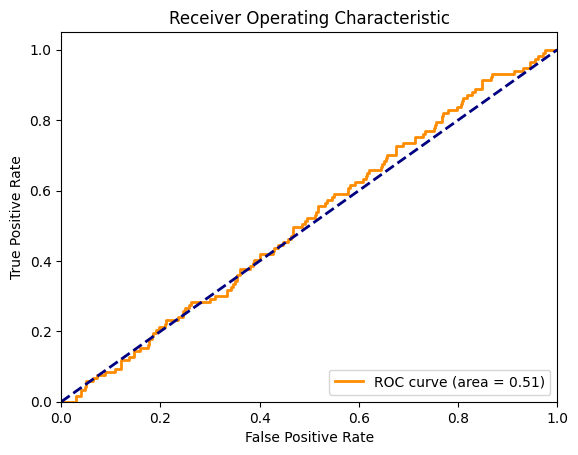

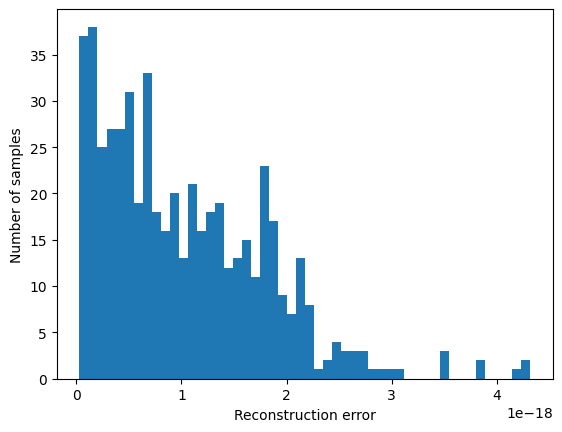

In [55]:
from tensorflow.keras import regularizers
from sklearn.metrics import precision_recall_curve, f1_score

# Function to build VAE model with updated architecture
def build_vae(input_shape, latent_dim):
    inputs = layers.Input(shape=(input_shape,))

    # Encoder
    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)

    z = Sampling()([z_mean, z_log_var])

    # Decoder
    decoder_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(decoder_inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(input_shape, activation='sigmoid')(x)

    encoder = models.Model(inputs, [z_mean, z_log_var, z])
    decoder = models.Model(decoder_inputs, outputs)

    vae_outputs = decoder(encoder(inputs)[2])
    vae = models.Model(inputs, vae_outputs)

    custom_layer = CustomVariationalLayer()([inputs, z_mean, z_log_var, vae_outputs])
    vae = models.Model(inputs, custom_layer)
    vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

    return vae, encoder, decoder

# Build and fine-tune the VAE on the current dataset
latent_dim = 50  # Increase latent dimension
vae_current, encoder_current, decoder_current = build_vae(X_preprocessed.shape[1], latent_dim)

history_current = vae_current.fit(X_train_res, X_train_res, epochs=400, batch_size=32, validation_split=0.2, verbose=1, callbacks=[
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)
])

# Save the trained VAE using the HDF5 format
vae_current.save('vae_current.h5')

# Load the trained VAE model
vae_current = tf.keras.models.load_model(
    'vae_current.h5',
    custom_objects={'Sampling': Sampling, 'CustomVariationalLayer': CustomVariationalLayer}
)

# Recompile the model to ensure metrics are available
vae_current.compile(optimizer='adam')

# Evaluate the VAE
X_test_pred = vae_current.predict(X_test)
reconstruction_loss = np.mean(np.square(X_test - X_test_pred), axis=1)

# Precision-Recall Curve for Optimal Threshold
precision, recall, thresholds = precision_recall_curve(y_test, reconstruction_loss)
f1_scores = [f1_score(y_test, reconstruction_loss > thr) for thr in thresholds]
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

y_pred_optimal = (reconstruction_loss > optimal_threshold).astype(int)

print(f"Optimal threshold: {optimal_threshold}")
print(classification_report(y_test, y_pred_optimal))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, reconstruction_loss)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC: {roc_auc}")

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Visualization of Reconstruction Error
plt.hist(reconstruction_loss, bins=50)
plt.xlabel("Reconstruction error")
plt.ylabel("Number of samples")
plt.show()


## ***Peprjekje 2 per ta optimizuar***

1. Class imbalance handling
2. Adjusting threshold for Anomaly Detetion
3. Changed model architecture

Shape of X_1: (3425, 2455)
Shape of y_1: (3425,)
Epoch 1/200
86/86 [==============================] - 3s 18ms/step - loss: 0.2507 - val_loss: 0.0107
Epoch 2/200
86/86 [==============================] - 2s 25ms/step - loss: 0.0097 - val_loss: 0.0060
Epoch 3/200
86/86 [==============================] - 2s 26ms/step - loss: 0.0076 - val_loss: 0.0051
Epoch 4/200
86/86 [==============================] - 2s 26ms/step - loss: 0.0071 - val_loss: 0.0056
Epoch 5/200
86/86 [==============================] - 2s 29ms/step - loss: 0.0071 - val_loss: 0.0055
Epoch 6/200
86/86 [==============================] - 3s 30ms/step - loss: 0.0071 - val_loss: 0.0057
Epoch 7/200
86/86 [==============================] - 2s 22ms/step - loss: 0.0068 - val_loss: 0.0051
Epoch 8/200
86/86 [==============================] - 2s 26ms/step - loss: 0.0069 - val_loss: 0.0053
Epoch 9/200
86/86 [==============================] - 2s 23ms/step - loss: 0.0068 - val_loss: 0.0054
Epoch 10/200
86/86 [==============================]

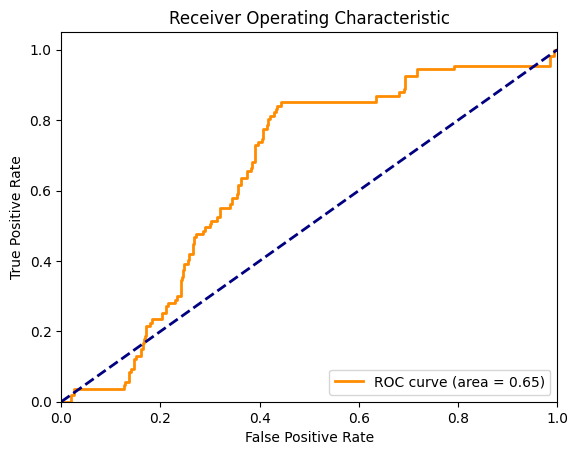


Classification Report with Optimal Threshold:
              precision    recall  f1-score   support

           0       0.93      0.56      0.70       427
           1       0.32      0.84      0.47       107

    accuracy                           0.61       534
   macro avg       0.63      0.70      0.58       534
weighted avg       0.81      0.61      0.65       534



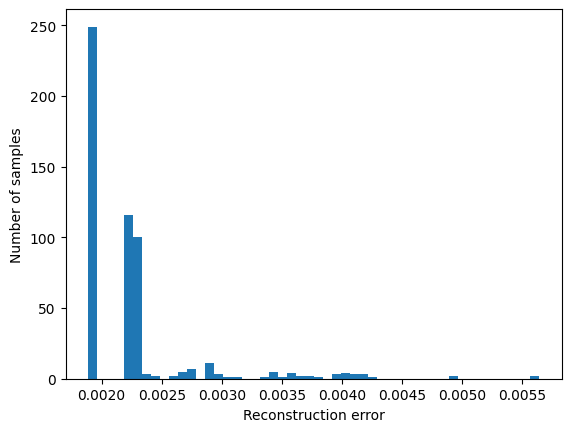

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_curve, auc
import tensorflow as tf
from tensorflow.keras import layers, models, losses

# Custom Sampling Layer
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Function to build VAE model with custom Sampling layer
def build_vae(input_shape, latent_dim):
    inputs = layers.Input(shape=(input_shape,))

    # Encoder
    x = layers.Dense(128, activation='relu')(inputs)
    x = layers.Dense(64, activation='relu')(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)

    z = Sampling()([z_mean, z_log_var])

    # Decoder
    decoder_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(64, activation='relu')(decoder_inputs)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(input_shape, activation='sigmoid')(x)

    encoder = models.Model(inputs, [z_mean, z_log_var, z])
    decoder = models.Model(decoder_inputs, outputs)

    vae_outputs = decoder(encoder(inputs)[2])
    vae = models.Model(inputs, vae_outputs)

    reconstruction_loss = losses.binary_crossentropy(inputs, vae_outputs)
    kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
    vae_loss = reconstruction_loss + kl_loss
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')

    return vae, encoder, decoder

# Load and preprocess the first dataset
data_file_1 = "Book1.xlsx"
df_1 = pd.read_excel(data_file_1, sheet_name="Sheet1", header=0)

if 'CodiceTipo' in df_1.columns:
    df_1['Target'] = df_1['CodiceTipo'].apply(lambda x: 1 if x == 6 else 0)
else:
    raise ValueError("'CodiceTipo' column not found in the dataset.")

df_1.rename(columns={
    'Codice': 'idAnomalia',
    'CodiceTipo': 'note',
    'DataOraRicezione': 'dataAnomalia',
    'Latitudine': 'latitudine',
    'Longitudine': 'longitudine',
    'DataOraRilevazione': 'dataCoordinate',
    'DataOraCreazione': 'dataSegnalazione',
    'Semirimorchio': 'idConcentratore'
}, inplace=True)

datetime_columns_1 = ['dataAnomalia', 'dataCoordinate', 'dataSegnalazione']
for col in datetime_columns_1:
    df_1[col] = pd.to_datetime(df_1[col], errors='coerce')
    df_1[col] = df_1[col].astype('int64') // 10**9

for col in datetime_columns_1:
    df_1[col] = df_1[col].fillna(df_1[col].median())

df_1['Autista'] = df_1['Autista'].astype(str)
df_1['CIM'] = df_1['CIM'].astype(str)
df_1['Valore'] = df_1['Valore'].astype(str)
df_1['Anteprima'] = df_1['Anteprima'].astype(str)

numeric_features_1 = df_1.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features_1 = df_1.select_dtypes(include=['object']).columns.tolist()

if 'Target' in numeric_features_1:
    numeric_features_1.remove('Target')
if 'Target' in categorical_features_1:
    categorical_features_1.remove('Target')

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features_1),
        ('cat', categorical_transformer, categorical_features_1)
    ]
)

X_1 = preprocessor.fit_transform(df_1.drop(columns=['Target']))
y_1 = df_1['Target']

print(f"Shape of X_1: {X_1.shape}")
print(f"Shape of y_1: {y_1.shape}")

# Build and train VAE on the first dataset
input_shape = X_1.shape[1]
latent_dim = 2
vae_additional, encoder_additional, decoder_additional = build_vae(input_shape, latent_dim)

history_additional = vae_additional.fit(X_1, X_1, epochs=200, batch_size=32, validation_split=0.2, verbose=1)

# Save the model using SavedModel format
vae_additional.save('vae_additional', save_format='tf')

# Load the model
vae_additional = tf.keras.models.load_model('vae_additional', custom_objects={'Sampling': Sampling})

# Load and preprocess the current dataset
data_file = "Anomalies_2021_2024.xlsx"
df = pd.read_excel(data_file, sheet_name="Sheet1", header=0)

df['Target'] = df.apply(lambda row: 1 if pd.isnull(row['idPunto']) and row['note'] in [12, 6] else 0, axis=1)
df = df.drop(columns=['idPunto', 'note'])

datetime_columns = ['dataAnomalia', 'dataCoordinate', 'dataSegnalazione']
for col in datetime_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')
    df[col] = df[col].astype('int64') // 10**9

for col in datetime_columns:
    df[col].fillna(df[col].median(), inplace=True)

categorical_features = df.select_dtypes(include=['object']).columns
df[categorical_features] = df[categorical_features].astype(str)

X = df.drop(columns=['Target'])
y = df['Target']

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

X_preprocessed = preprocessor.fit_transform(X)

print(f"Shape of X_preprocessed: {X_preprocessed.shape}")
print(f"Shape of y: {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Build and fine-tune the VAE on the current dataset
vae, encoder, decoder = build_vae(X_preprocessed.shape[1], latent_dim)

# Load the additional VAE model
vae_additional = tf.keras.models.load_model('vae_additional', custom_objects={'Sampling': Sampling})

# Fine-tune the VAE on the current dataset
history = vae.fit(X_train, X_train, epochs=150, batch_size=32, validation_split=0.2, verbose=1)

# Predict on the test set
X_test_pred = vae.predict(X_test)

# Calculate reconstruction error
reconstruction_loss = np.mean(np.square(X_test - X_test_pred), axis=1)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, reconstruction_loss)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Find optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Use the optimal threshold for anomaly detection
y_pred_optimal = (reconstruction_loss > optimal_threshold).astype(int)

# Print the classification report
print("\nClassification Report with Optimal Threshold:")
print(classification_report(y_test, y_pred_optimal))

# Visualize the reconstruction error
plt.hist(reconstruction_loss, bins=50)
plt.xlabel("Reconstruction error")
plt.ylabel("Number of samples")
plt.show()


## **perpjekja 1 me ndryshim threshold dhe metrikash**

Shape of X_1: (3425, 2455)
Shape of y_1: (3425,)
Epoch 1/200
86/86 [==============================] - 5s 24ms/step - loss: 0.2499 - val_loss: 0.0113
Epoch 2/200
86/86 [==============================] - 1s 14ms/step - loss: 0.0097 - val_loss: 0.0063
Epoch 3/200
86/86 [==============================] - 1s 14ms/step - loss: 0.0077 - val_loss: 0.0052
Epoch 4/200
86/86 [==============================] - 1s 14ms/step - loss: 0.0073 - val_loss: 0.0057
Epoch 5/200
86/86 [==============================] - 1s 14ms/step - loss: 0.0070 - val_loss: 0.0057
Epoch 6/200
86/86 [==============================] - 1s 14ms/step - loss: 0.0070 - val_loss: 0.0054
Epoch 7/200
86/86 [==============================] - 1s 15ms/step - loss: 0.0070 - val_loss: 0.0049
Epoch 8/200
86/86 [==============================] - 1s 15ms/step - loss: 0.0070 - val_loss: 0.0053
Epoch 9/200
86/86 [==============================] - 2s 18ms/step - loss: 0.0069 - val_loss: 0.0056
Epoch 10/200
86/86 [==============================]

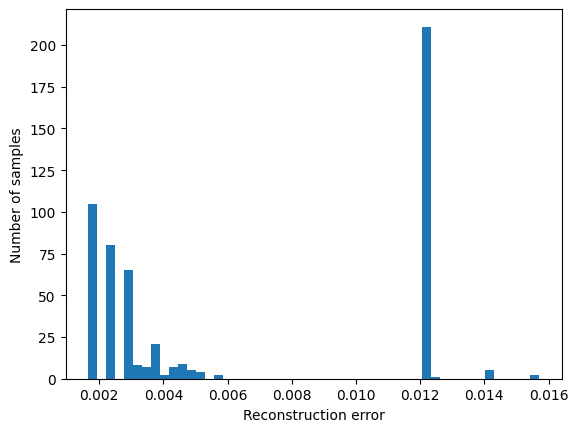

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import layers, models, losses

# Custom Sampling Layer
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Function to build VAE model with custom Sampling layer
def build_vae(input_shape, latent_dim):
    inputs = layers.Input(shape=(input_shape,))

    # Encoder
    x = layers.Dense(128, activation='relu')(inputs)
    x = layers.Dense(64, activation='relu')(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)

    z = Sampling()([z_mean, z_log_var])

    # Decoder
    decoder_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(64, activation='relu')(decoder_inputs)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(input_shape, activation='sigmoid')(x)

    encoder = models.Model(inputs, [z_mean, z_log_var, z])
    decoder = models.Model(decoder_inputs, outputs)

    vae_outputs = decoder(encoder(inputs)[2])
    vae = models.Model(inputs, vae_outputs)

    reconstruction_loss = losses.binary_crossentropy(inputs, vae_outputs)
    kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
    vae_loss = reconstruction_loss + kl_loss
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')

    return vae, encoder, decoder

# Load and preprocess the first dataset
data_file_1 = "Book1.xlsx"
df_1 = pd.read_excel(data_file_1, sheet_name="Sheet1", header=0)

if 'CodiceTipo' in df_1.columns:
    df_1['Target'] = df_1['CodiceTipo'].apply(lambda x: 1 if x == 6 else 0)
else:
    raise ValueError("'CodiceTipo' column not found in the dataset.")

df_1.rename(columns={
    'Codice': 'idAnomalia',
    'CodiceTipo': 'note',
    'DataOraRicezione': 'dataAnomalia',
    'Latitudine': 'latitudine',
    'Longitudine': 'longitudine',
    'DataOraRilevazione': 'dataCoordinate',
    'DataOraCreazione': 'dataSegnalazione',
    'Semirimorchio': 'idConcentratore'
}, inplace=True)

datetime_columns_1 = ['dataAnomalia', 'dataCoordinate', 'dataSegnalazione']
for col in datetime_columns_1:
    df_1[col] = pd.to_datetime(df_1[col], errors='coerce')
    df_1[col] = df_1[col].astype('int64') // 10**9

for col in datetime_columns_1:
    df_1[col] = df_1[col].fillna(df_1[col].median())

df_1['Autista'] = df_1['Autista'].astype(str)
df_1['CIM'] = df_1['CIM'].astype(str)
df_1['Valore'] = df_1['Valore'].astype(str)
df_1['Anteprima'] = df_1['Anteprima'].astype(str)

numeric_features_1 = df_1.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features_1 = df_1.select_dtypes(include=['object']).columns.tolist()

if 'Target' in numeric_features_1:
    numeric_features_1.remove('Target')
if 'Target' in categorical_features_1:
    categorical_features_1.remove('Target')

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features_1),
        ('cat', categorical_transformer, categorical_features_1)
    ]
)

X_1 = preprocessor.fit_transform(df_1.drop(columns=['Target']))
y_1 = df_1['Target']

print(f"Shape of X_1: {X_1.shape}")
print(f"Shape of y_1: {y_1.shape}")

# Build and train VAE on the first dataset
input_shape = X_1.shape[1]
latent_dim = 2
vae_additional, encoder_additional, decoder_additional = build_vae(input_shape, latent_dim)

history_additional = vae_additional.fit(X_1, X_1, epochs=200, batch_size=32, validation_split=0.2, verbose=1)

# Save the model using SavedModel format
vae_additional.save('vae_additional', save_format='tf')

# Load the model
vae_additional = tf.keras.models.load_model('vae_additional', custom_objects={'Sampling': Sampling})

# Load and preprocess the current dataset
data_file = "Anomalies_2021_2024.xlsx"
df = pd.read_excel(data_file, sheet_name="Sheet1", header=0)

df['Target'] = df.apply(lambda row: 1 if pd.isnull(row['idPunto']) and row['note'] in [12, 6] else 0, axis=1)
df = df.drop(columns=['idPunto', 'note'])

datetime_columns = ['dataAnomalia', 'dataCoordinate', 'dataSegnalazione']
for col in datetime_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')
    df[col] = df[col].astype('int64') // 10**9

for col in datetime_columns:
    df[col].fillna(df[col].median(), inplace=True)

categorical_features = df.select_dtypes(include=['object']).columns
df[categorical_features] = df[categorical_features].astype(str)

X = df.drop(columns=['Target'])
y = df['Target']

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

X_preprocessed = preprocessor.fit_transform(X)

print(f"Shape of X_preprocessed: {X_preprocessed.shape}")
print(f"Shape of y: {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Build and fine-tune the VAE on the current dataset
vae, encoder, decoder = build_vae(X_preprocessed.shape[1], latent_dim)

# Load the additional VAE model
vae_additional = tf.keras.models.load_model('vae_additional', custom_objects={'Sampling': Sampling})

# Fine-tune the VAE on the current dataset
history = vae.fit(X_train, X_train, epochs=200, batch_size=32, validation_split=0.2, verbose=1)

# Predict on the test set
X_test_pred = vae.predict(X_test)

# Calculate reconstruction error
reconstruction_loss = np.mean(np.square(X_test - X_test_pred), axis=1)

# Define a threshold for anomaly detection
threshold = np.percentile(reconstruction_loss, 70)
y_pred = (reconstruction_loss > threshold).astype(int)

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Visualize the reconstruction error
plt.hist(reconstruction_loss, bins=50)
plt.xlabel("Reconstruction error")
plt.ylabel("Number of samples")
plt.show()


## stepe 1: Train the Initial VAE Model on the Book1 Datatset

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras import layers, models, losses

# Load and preprocess the Book1 dataset
data_file_1 = "Book1.xlsx"
df_1 = pd.read_excel(data_file_1, sheet_name="Sheet1", header=0)

df_1['Target'] = df_1['CodiceTipo'].apply(lambda x: 1 if x == 6 else 0)
df_1.rename(columns={
    'Codice': 'idAnomalia',
    'CodiceTipo': 'note',
    'DataOraRicezione': 'dataAnomalia',
    'Latitudine': 'latitudine',
    'Longitudine': 'longitudine',
    'DataOraRilevazione': 'dataCoordinate',
    'DataOraCreazione': 'dataSegnalazione',
    'Semirimorchio': 'idConcentratore'
}, inplace=True)

datetime_columns_1 = ['dataAnomalia', 'dataCoordinate', 'dataSegnalazione']
for col in datetime_columns_1:
    df_1[col] = pd.to_datetime(df_1[col], errors='coerce')
    df_1[col] = df_1[col].astype('int64') // 10**9

for col in datetime_columns_1:
    df_1[col] = df_1[col].fillna(df_1[col].median())

df_1['Autista'] = df_1['Autista'].astype(str)
df_1['CIM'] = df_1['CIM'].astype(str)
df_1['Valore'] = df_1['Valore'].astype(str)
df_1['Anteprima'] = df_1['Anteprima'].astype(str)

numeric_features_1 = df_1.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features_1 = df_1.select_dtypes(include=['object']).columns.tolist()

if 'Target' in numeric_features_1:
    numeric_features_1.remove('Target')
if 'Target' in categorical_features_1:
    categorical_features_1.remove('Target')

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features_1),
        ('cat', categorical_transformer, categorical_features_1)
    ]
)

X_1 = preprocessor.fit_transform(df_1.drop(columns=['Target']))
y_1 = df_1['Target']

input_shape = X_1.shape[1]
latent_dim = 2

# Define the sampling function
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Function to build VAE model
def build_vae(input_shape, latent_dim):
    inputs = layers.Input(shape=(input_shape,))

    # Encoder
    x = layers.Dense(128, activation='relu')(inputs)
    x = layers.Dense(64, activation='relu')(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)

    z = layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    # Decoder
    decoder_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(64, activation='relu')(decoder_inputs)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(input_shape, activation='sigmoid')(x)

    encoder = models.Model(inputs, [z_mean, z_log_var, z])
    decoder = models.Model(decoder_inputs, outputs)

    vae_outputs = decoder(encoder(inputs)[2])
    vae = models.Model(inputs, vae_outputs)

    reconstruction_loss = losses.binary_crossentropy(inputs, vae_outputs)
    kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
    vae_loss = reconstruction_loss + kl_loss
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')

    return vae, encoder, decoder

# Build and train the VAE on the Book1 dataset
vae, encoder, decoder = build_vae(input_shape, latent_dim)
history_additional = vae.fit(X_1, X_1, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Save the VAE model in TensorFlow native format
vae.save('vae_additional.keras')


KeyboardInterrupt: 

## Step 2: Extrat Feature using the VAE encoder

In [ ]:
# Load the additional VAE model
vae_additional = tf.keras.models.load_model('vae_additional.keras', custom_objects={'sampling': sampling})

# Extract features using the encoder part of the VAE
def extract_features(data, encoder):
    z_mean, _, _ = encoder.predict(data)
    return z_mean

# Load and preprocess the current dataset
data_file = "Anomalies_2021_2024.xlsx"
df = pd.read_excel(data_file, sheet_name="Sheet1", header=0)

df['Target'] = df.apply(lambda row: 1 if pd.isnull(row['idPunto']) and row['note'] in [12, 6] else 0, axis=1)
df = df.drop(columns=['idPunto', 'note'])

datetime_columns = ['dataAnomalia', 'dataCoordinate', 'dataSegnalazione']
for col in datetime_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')
    df[col] = df[col].astype('int64') // 10**9

for col in datetime_columns:
    df[col].fillna(df[col].median(), inplace=True)

categorical_features = df.select_dtypes(include=['object']).columns
df[categorical_features] = df[categorical_features].astype(str)

numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

X = preprocessor.fit_transform(df.drop(columns=['Target']))
y = df['Target']

X_features = extract_features(X, encoder)


## Step 3: Train a Classifier on the Extracted Features

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)

# Train a RandomForest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Step 5: Visualization

In [ ]:
# Calculate reconstruction error for the test set
X_test_pred = vae.predict(X_test)
reconstruction_loss = np.mean(np.square(X_test - X_test_pred), axis=1)

# Define a threshold for anomaly detection
threshold = np.percentile(reconstruction_loss, 85)
y_pred_reconstruction = (reconstruction_loss > threshold).astype(int)

# Visualize the reconstruction error
plt.hist(reconstruction_loss, bins=50)
plt.xlabel("Reconstruction error")
plt.ylabel("Number of samples")
plt.show()

print("\nReconstruction-Based Classification Report:")
print(classification_report(y_test, y_pred_reconstruction))
